# What Makes or Breaks an Airbnb?

### <u>The problem</u>

The housing crisis is affecting towns and cities worldwide, with high demand and short supply resulting in a lack of affordable housing for the average buyer or renter. This crisis is particularly acute in tourist hotspots where the rise of short-term rentals is taking more properties off the market, away from long-term dwellers.

Airbnb is an online platform that launched in 2008, allowing travellers to book more authentic and affordable short-term stays compared to a prefabricated and pricier hotel experience. Increasingly, property investors looking to expand their portfolios have seen how lucrative Airbnb rentals are. Coupled with poor regulation of Airbnb rentals that outstay their terms, this has only added fuel to the fire. According to <u><a href="https://www.wired.co.uk/article/airbnb-london-short-term-rentals">Wired</a></u>, 56% of London Airbnb listings comprised of entire homes by 2019, and the number of listings in the city's more suburban quarters had increased fifteen-fold compared to four years prior.

This project presents a potential solution to this problem - using machine learning to accurately predict the price of an Airbnb listing. If we can accurately predict the price, then we know what factors and variables influence pricing the most. This information can support current research and, once escalated, could be used as part of lobbying tactics to protect certain areas and types of housing from Airbnb investment based on these factors.

Since price is a continuous variable and data labelled with this known target is needed to make predictions, I will be using supervised regression models to solve this problem. RMSE (root mean squared error) is the metric of choice used to measure the performance of each model used in this project.

In [145]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statistics as stats

import geopy

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

import statsmodels.api as sm
import statsmodels.tools
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor


%matplotlib inline

## 1. Exploratory Data Analysis

In [35]:
# Read in London weekday data
london_wd = pd.read_csv("Datasets/Kaggle/london_weekdays.csv")
london_wd.rename(columns={'Unnamed: 0': 'city'}, inplace=True)
london_wd['city'] = 'London'
london_wd['is_weekend'] = False

# Read in London weekend data
london_we = pd.read_csv("Datasets/Kaggle/london_weekends.csv")
london_we.rename(columns={'Unnamed: 0': 'city'}, inplace=True)
london_we['city'] = 'London'
london_we['is_weekend'] = True

# Combine datasets for one complete set
london = pd.concat([london_wd, london_we])

# Create a copy for EDA and modelling
london_copy = london.copy()
london_copy.head(20)

city     realSum        room_type  room_shared  room_private  \
0   London  570.098074  Entire home/apt        False         False   
1   London  297.984430     Private room        False          True   
2   London  336.790611     Private room        False          True   
3   London  226.722171     Private room        False          True   
4   London  256.355982     Private room        False          True   
5   London  239.892754     Private room        False          True   
6   London  324.090407     Private room        False          True   
7   London  155.695101     Private room        False          True   
8   London  129.353936     Private room        False          True   
9   London  246.007667  Entire home/apt        False         False   
10  London  220.136880  Entire home/apt        False         False   
11  London  362.896587  Entire home/apt        False         False   
12  London  207.436675     Private room        False          True   
13  London  285.049037     Private room        False          True   
14  London  505.185917  Entire home/apt        False         False   
15  London  142.524518     Private room        False          True   
16  London  310.919824     Private room        False          True   
17  London  608.904255  Entire home/apt        False         False   
18  London  207.436675     Private room        False          True   
19  London  194.501282     Private room        False          True   

    person_capacity  host_is_superhost  multi  biz  cleanliness_rating  ...  \
0               2.0              False      0    0                10.0  ...   
1               2.0               True      1    0                10.0  ...   
2               2.0              False      1    0                10.0  ...   
3               2.0               True      1    0                10.0  ...   
4               3.0              False      0    0                 9.0  ...   
5               2.0              False      0    0                10.0  ...   
6               2.0              False      0    0                10.0  ...   
7               2.0              False      1    0                10.0  ...   
8               4.0              False      1    0                 9.0  ...   
9               3.0              False      0    1                 8.0  ...   
10              2.0              False      0    1                 9.0  ...   
11              2.0              False      1    0                 8.0  ...   
12              2.0              False      0    0                 4.0  ...   
13              2.0               True      1    0                 9.0  ...   
14              4.0              False      0    1                 9.0  ...   
15              2.0              False      0    0                10.0  ...   
16              2.0              False      0    0                 9.0  ...   
17              4.0              False      0    0                10.0  ...   
18              2.0               True      1    0                10.0  ...   
19              2.0              False      1    0                10.0  ...   

    bedrooms      dist  metro_dist  attr_index  attr_index_norm  rest_index  \
0          1  5.301018    1.588990  209.632578        14.571793  467.597522   
1          1  2.198946    0.379262  553.891744        38.501630  961.472137   
2          1  2.322958    0.453178  428.287849        29.770764  959.042839   
3          1  5.707825    1.723977  195.694744        13.602959  452.232472   
4          1  3.257945    0.825417  329.477068        22.902317  735.327280   
5          1  5.085730    1.806218  226.724964        15.759904  486.737052   
6          1  4.595055    0.296879  283.442608        19.702410  682.186718   
7          1  5.102453    1.013706  214.263962        14.893726  453.668124   
8          1  4.534041    1.772806  257.445014        17.895289  541.216973   
9          0  3.746655    0.417554  332.044947        23.080813  761.652285   
10    

### <u>Background</u>

The data was downloaded from Kaggle but originally collected by a research group at The University of Warsaw as part of <b><u><a href="https://www.sciencedirect.com/science/article/pii/S0261517721000388?via%3Dihub">a 2019 study</a></u></b> that attempted to predict the price of Airbnb listings across selected European cities.

Only data from London is included in this project. Data related to London Airbnb listings such as price and location coordinates was collected between 28th June 2019 and 12th July 2019, based on Airbnb search results for 2 people and 2 nights 4-6 weeks ahead of a booking. Bookings covered either weekdays (Tuesday to Thursday) or weekends (Friday to Sunday). Data in this set was also scrapped from TripAdvisor, to describe a listing's proximity to an abundance of tourist attractions and restaurants.

The prices included in the dataset are based on advertised prices which can be set by the host, not prices that previous customers had actually paid. Only listings that could host a maximum of 6 people and had at least 1 review were included in the dataset. Finally, the data includes Airbnb listings from inner London only, and none from outer London. That's because the University of Warsaw research group wanted to make a fairer comparison between London and much smaller European cities included in their study.

### <u>Columns</u>

<table>
    <tr>
        <td><i>realSum</i></td>
        <td>The total price of the Airbnb listing for 2 people and 2 nights, in EUR.</td>
    </tr>
    <tr>
        <td><i>room_type</i></td>
        <td>The type of room being offered (e.g. private, shared, entire home).</td>
    </tr>
    <tr>
        <td><i>room_shared</i></td>
        <td>Whether the room is shared or not.</td>
    </tr>
    <tr>
        <td><i>room_private</i></td>
        <td>Whether the room is private or not.</td>
    </tr>
    <tr>
        <td><i>person_capacity</i></td>
        <td>The maximum number of people that can stay in the room.</td>
    </tr>
    <tr>
        <td><i>host_is_superhost</i></td>
        <td>Whether the host is a superhost or not.</td>
    </tr>
    <tr>
        <td><i>multi</i></td>
        <td>Whether the host of the listing owns 2-4 Airbnb listings in total or not.</td>
    </tr>
    <tr>
        <td><i>biz</i></td>
        <td>Whether the host of the listing owns at least 5 Airbnb listings in total or not.</td>
    </tr>
    <tr>
        <td><i>cleanliness_rating</i></td>
        <td>The cleanliness rating of the listing.</td>
    </tr>
    <tr>
        <td><i>guest_satisfaction_overall</i></td>
        <td>The overall guest satisfaction rating of the listing.</td>
    </tr>
    <tr>
        <td><i>bedrooms</i></td>
        <td>The number of bedrooms in the listing.</td>
    </tr>
    <tr>
        <td><i>dist</i></td>
        <td>The Euclidean distance from the city centre (Trafalgar Square).</td>
    </tr>
    <tr>
        <td><i>metro_dist</i></td>
        <td>The Euclidean distance from the nearest metro station, using coordinates of metro stations scraped from Wikipedia.</td>
    </tr>
    <tr>
        <td><i>attr_index</i></td>
        <td>Attraction index - a measure of how close a listing is to an abundance of tourist attractions and places of interest.</td>
    </tr>
    <tr>
        <td><i>attr_index_norm</i></td>
        <td>Attraction index but normalised.</td>
    </tr>
    <tr>
        <td><i>rest_index</i></td>
        <td>Restaurant index - a measure of how close a listing is to an abundance of restaurants.</td>
    </tr>
    <tr>
        <td><i>rest_index_norm</i></td>
        <td>Restaurant index but normalised.</td>
    </tr>
    <tr>
        <td><i>lng</i></td>
        <td>The longitudinal coordinate of the listing.</td>
    </tr>
    <tr>
        <td><i>lat</i></td>
        <td>The latitudinal coordinate of the listing.</td>
    </tr>
    <tr>
        <td><i>is_weekend</i></td>
        <td>Whether the listing is for a weekend booking or not.</td>
    </tr>
</table>

In [3]:
london_copy.columns

Index(['city', 'realSum', 'room_type', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat', 'is_weekend'],
      dtype='object')

<u>Identifying the target variable:</u>

'realSum' is the target variable but we need to transform it into data that's more meaningful and contextualised.
'realSum' is the total price (in EUR) of a listing for 2 people and 2 nights, but it would be better to present this in GBP for 1 person and 1 night.

The exchange rates seen below were taken from <u><a href="https://www.exchangerates.org.uk/EUR-GBP-spot-exchange-rates-history-2019.html">this website</a></u>.

In [36]:
# First, calculate the average exchange rate between 28/06/2019 and 12/07/2019 (i.e. when the price data was collected)
rates = [0.8964,0.8964,0.8953,0.8841,0.8973,0.8913,0.8925,0.8964,0.8973,0.8972,0.8972,0.8969,0.8964,0.896,0.8995,0.9003,0.8984,0.8973]
mean_rates = stats.mean(rates)

# Next, divide 'realSum' by 4 (2 nights and 2 people) and multiply by the mean exchange rate to get the new column
london_copy['price'] = (london_copy['realSum'] / 4) * mean_rates

A lot of this data was preprocessed before being discovered. Some columns present are actually dummies created by one-hot encoding previous columns:

<ul>
<li>'host_is_superhost' is a dummy for a variable measuring if a host is a superhost or not - the dummy for 'not_superhost' was dropped. We don't need to reverse one-hot encode since this variable only takes 2 values.</li>

<li>'room_shared' and 'room_private' are dummies for 'room_type' - the dummy for entire house/apartment was dropped. We don't need to reverse one-hot encode since the original variable 'room_type' already exists in the dataset. We can create a new dummy for the 'Entire Home/Apt' value for this variable though.</li>

<li>There are also dummies for a variable that tells us if a listing belongs to a host with a certain number of listings in total - 'multi' (2-4 listings) and 'biz' (more than 4 listings). 'single' (1 listing) is a dummy that was dropped but can be brought back here.</li>
</ul>

In [37]:
# Create new dummy for the 'Entire Home/Apt' in 'room_type'
entire_home = []
for i in range(0, london_copy.shape[0]):
    if london_copy.iloc[i, list(london_copy.columns).index('room_type')] == 'Entire home/apt':
        entire_home.append(True)
    else:
        entire_home.append(False)
london_copy['room_entire_home'] = entire_home

# Create new dummy relating to listings owned by hosts with no other Airbnb listings
single = []
for i in range(0, london_copy.shape[0]):
    if london_copy.iloc[i, list(london_copy.columns).index('multi')] == 0 and london_copy.iloc[i, list(london_copy.columns).index('biz')] == 0:
        single.append(1)
    else:
        single.append(0)
london_copy['single'] = single

# Reverse one-hot encode 'single', 'multi' and 'biz' to get the original that measures the number of listings per host
london_copy['host_type'] = (london_copy[['single','multi','biz']] == 1).idxmax(1)

# Rearrange columns
london_copy = london_copy[['city', 'realSum', 'price', 'room_type', 'room_entire_home', 'room_shared', 'room_private', 'person_capacity', 'host_is_superhost', 'host_type', 'single', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat', 'is_weekend']]
london_copy.head()

city     realSum       price        room_type  room_entire_home  \
0  London  570.098074  127.687716  Entire home/apt              True   
1  London  297.984430   66.741063     Private room             False   
2  London  336.790611   75.432677     Private room             False   
3  London  226.722171   50.780098     Private room             False   
4  London  256.355982   57.417331     Private room             False   

   room_shared  room_private  person_capacity  host_is_superhost host_type  \
0        False         False              2.0              False    single   
1        False          True              2.0               True     multi   
2        False          True              2.0              False     multi   
3        False          True              2.0               True     multi   
4        False          True              3.0              False    single   

   ...  bedrooms      dist  metro_dist  attr_index  attr_index_norm  \
0  ...         1  5.301018    1.588990  209.632578        14.571793   
1  ...         1  2.198946    0.379262  553.891744        38.501630   
2  ...         1  2.322958    0.453178  428.287849        29.770764   
3  ...         1  5.707825    1.723977  195.694744        13.602959   
4  ...         1  3.257945    0.825417  329.477068        22.902317   

   rest_index  rest_index_norm      lng       lat  is_weekend  
0  467.597522         8.372724 -0.16032  51.46531       False  
1  961.472137        17.215961 -0.09683  51.50343       False  
2  959.042839        17.172462 -0.10554  51.52407       False  
3  452.232472         8.097600 -0.16575  51.46292       False  
4  735.327280        13.166649 -0.12055  51.53728       False  

[5 rows x 25 columns]

In [8]:
# Check the number of rows and columns within the dataset
london_copy.shape

(9993, 25)

In [9]:
# Check datatypes of the columns
london_copy.dtypes

city                           object
realSum                       float64
price                         float64
room_type                      object
room_entire_home                 bool
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
host_type                      object
single                          int64
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
is_weekend                       bool
dtype: object

In [38]:
# Change person_capacity to int64 data
london_copy['person_capacity'] = london_copy['person_capacity'].astype('int64')
london_copy.dtypes

city                           object
realSum                       float64
price                         float64
room_type                      object
room_entire_home                 bool
room_shared                      bool
room_private                     bool
person_capacity                 int64
host_is_superhost                bool
host_type                      object
single                          int64
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
is_weekend                       bool
dtype: object

### <u>Check for nulls</u>

In [386]:
# Create function that counts the number of nulls per column
def null_count(dataframe):
    null_vals = dataframe.isnull().sum()
    total_cnt = len(dataframe)
    null_vals = pd.DataFrame(null_vals,columns=['null'])
    null_vals['percent'] = round((null_vals['null']/total_cnt)*100,3)
    return null_vals.sort_values('percent', ascending=False)

# Apply function onto dataset
null_count(london_copy)

null  percent
city                           0      0.0
realSum                        0      0.0
lat                            0      0.0
lng                            0      0.0
rest_index_norm                0      0.0
rest_index                     0      0.0
attr_index_norm                0      0.0
attr_index                     0      0.0
metro_dist                     0      0.0
dist                           0      0.0
bedrooms                       0      0.0
guest_satisfaction_overall     0      0.0
cleanliness_rating             0      0.0
biz                            0      0.0
multi                          0      0.0
host_is_superhost              0      0.0
person_capacity                0      0.0
room_private                   0      0.0
room_shared                    0      0.0
room_type                      0      0.0
price                          0      0.0
is_weekend                     0      0.0

In [11]:
# Check for any empty string values in any of string columns
print(london_copy.room_type.value_counts())
print(f'The total number of values in this column = {len(london_copy.room_type)}')

Private room       5559
Entire home/apt    4384
Shared room          50
Name: room_type, dtype: int64
The total number of values in this column = 9993


This means that there are no nulls in the dataset that need to be dealt with.

### <u>Distribution of variables</u>

In [12]:
# Show summary statistics for numeric columns
london_copy.describe()

realSum        price  person_capacity       single        multi  \
count   9993.000000  9993.000000      9993.000000  9993.000000  9993.000000   
mean     362.469256    81.184052         2.846192     0.337136     0.274992   
std      471.357265   105.572243         1.246235     0.472755     0.446533   
min       54.328653    12.168260         2.000000     0.000000     0.000000   
25%      169.571250    37.979721         2.000000     0.000000     0.000000   
50%      261.294950    58.523537         2.000000     0.000000     0.000000   
75%      438.157059    98.136227         4.000000     1.000000     1.000000   
max    15499.894165  3471.588796         6.000000     1.000000     1.000000   

               biz  cleanliness_rating  guest_satisfaction_overall  \
count  9993.000000         9993.000000                 9993.000000   
mean      0.387872            9.175023                   90.645652   
std       0.487289            1.166180                   11.510622   
min       0.000000            2.000000                   20.000000   
25%       0.000000            9.000000                   87.000000   
50%       0.000000           10.000000                   94.000000   
75%       1.000000           10.000000                   99.000000   
max       1.000000           10.000000                  100.000000   

          bedrooms         dist   metro_dist   attr_index  attr_index_norm  \
count  9993.000000  9993.000000  9993.000000  9993.000000      9993.000000   
mean      1.128790     5.326421     1.005547   295.448532        20.537398   
std       0.579477     2.712573     1.263926   171.401698        11.914575   
min       0.000000     0.040553     0.013875    68.740487         4.778228   
25%       1.000000     3.549125     0.320943   177.577991        12.344088   
50%       1.000000     4.924121     0.530815   249.276621        17.327889   
75%       1.000000     6.836919     1.070676   361.410786        25.122161   
max       8.000000    17.321206     9.286229  1438.618956       100.000000   

        rest_index  rest_index_norm          lng          lat  
count  9993.000000      9993.000000  9993.000000  9993.000000  
mean    627.541611        11.234105    -0.114830    51.503367  
std     389.000019         6.963803     0.067824     0.031734  
min     140.521722         2.515094    -0.251700    51.414400  
25%     383.553180         6.864961    -0.170680    51.486000  
50%     528.626061         9.465474    -0.118180    51.509710  
75%     770.026639        13.783694    -0.067600    51.525160  
max    5587.136047       100.000000     0.120180    51.575820

#### 1. Price of a listing

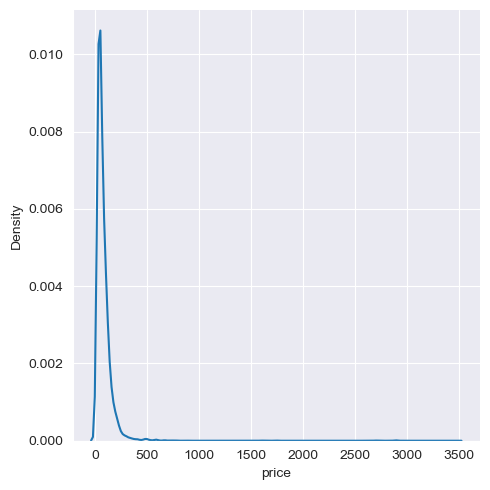

In [388]:
sns.displot(data=london_copy['price'], kind='kde')
plt.show()

'price' follows a log-normal distribution - this is typical of price variables seen in different problems such as predicting the price of a car or diamonds. Therefore, it may not be wise to disregard extreme values completely - especially with a simple method like the IQR * 1.5 Rule which doesn't account for how long the tail of the target's distribution actually is.

In [13]:
# Calculate outliers according to the IQR * 1.5 rule
outlier_threshold = (list(np.quantile(london_copy['price'], [0.25, 0.75]))[1] - list(np.quantile(london_copy['price'], [0.25, 0.75]))[0]) * 1.5

# Filter dataset by the outlier threshold and show summary stats
london_copy[london_copy['price'] > outlier_threshold].describe()

realSum        price  person_capacity       single        multi  \
count   2870.000000  2870.000000      2870.000000  2870.000000  2870.000000   
mean     718.531080   160.932999         3.988153     0.265157     0.215331   
std      760.702014   170.378234         1.386033     0.441494     0.411123   
min      403.113902    90.287436         2.000000     0.000000     0.000000   
25%      470.142760   105.300225         3.000000     0.000000     0.000000   
50%      561.748865   125.817702         4.000000     0.000000     0.000000   
75%      746.431007   167.181885         5.000000     1.000000     0.000000   
max    15499.894165  3471.588796         6.000000     1.000000     1.000000   

               biz  cleanliness_rating  guest_satisfaction_overall  \
count  2870.000000         2870.000000                 2870.000000   
mean      0.519512            9.169338                   89.750523   
std       0.499706            1.276610                   13.341081   
min       0.000000            2.000000                   20.000000   
25%       0.000000            9.000000                   86.000000   
50%       1.000000           10.000000                   93.000000   
75%       1.000000           10.000000                  100.000000   
max       1.000000           10.000000                  100.000000   

          bedrooms         dist   metro_dist   attr_index  attr_index_norm  \
count  2870.000000  2870.000000  2870.000000  2870.000000      2870.000000   
mean      1.511150     4.109056     0.599191   378.876637        26.336710   
std       0.726711     2.236208     0.704155   207.745360        14.440917   
min       0.000000     0.040553     0.020481    68.842055         4.785288   
25%       1.000000     2.610142     0.251362   236.751101        16.457036   
50%       1.000000     3.974118     0.402704   321.648515        22.359042   
75%       2.000000     5.106061     0.634861   455.343840        31.651773   
max       4.000000    17.295578     6.481097  1438.618956       100.000000   

        rest_index  rest_index_norm          lng          lat  
count  2870.000000      2870.000000  2870.000000  2870.000000  
mean    813.671746        14.566125    -0.132437    51.508482  
std     476.225857         8.525312     0.056224     0.022968  
min     140.521722         2.515094    -0.242710    51.417440  
25%     513.965613         9.199098    -0.178670    51.493963  
50%     709.003410        12.692760    -0.136995    51.512590  
75%     906.525768        16.230383    -0.094380    51.521160  
max    3894.782381        69.709818     0.120070    51.569550

In [16]:
# The vast majority of 'outlier' prices belong to entire home/apartment listings, but if we got rid of all these listings we would be losing over 50% of our observations! And a good chunk of these listings have prices that are still really close to the majority of the data, so this isn't advisable.
print(london_copy[london_copy['price'] > outlier_threshold]['room_type'].value_counts())
print(london_copy['room_type'].value_counts())

Entire home/apt    2619
Private room        249
Shared room           2
Name: room_type, dtype: int64
Private room       5559
Entire home/apt    4384
Shared room          50
Name: room_type, dtype: int64


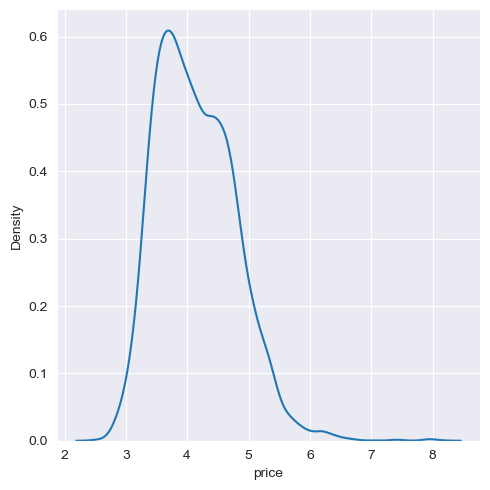

In [390]:
# We can log-transform our target for a more normal distribution
sns.displot(data=np.log(london_copy['price']), kind='kde')
plt.show()

#### 2. Number of bedrooms

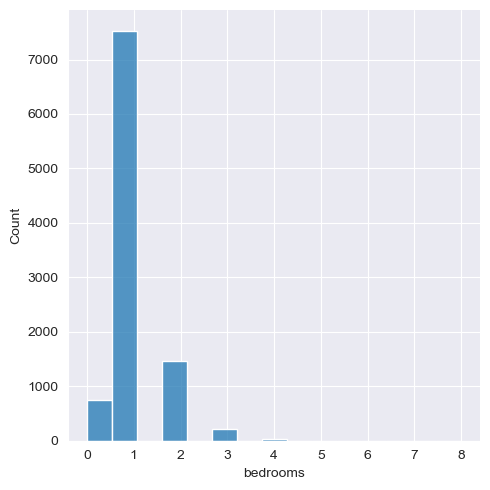

In [28]:
sns.displot(data=london_copy['bedrooms'])
plt.show()

#### 3. Distance from city centre

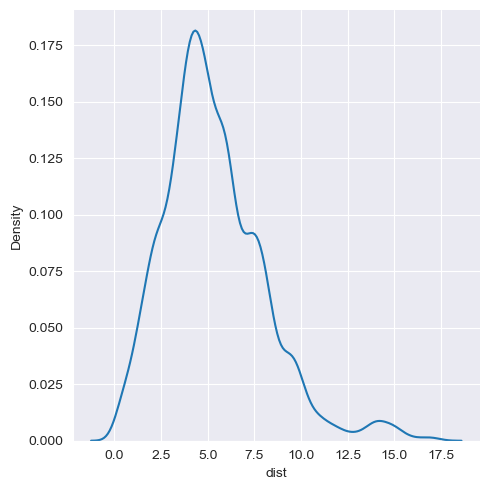

In [102]:
# There is some resemblance to a normal distribution
sns.displot(data=london_copy['dist'], kind='kde')
plt.show()

#### 4. Distance from nearest station

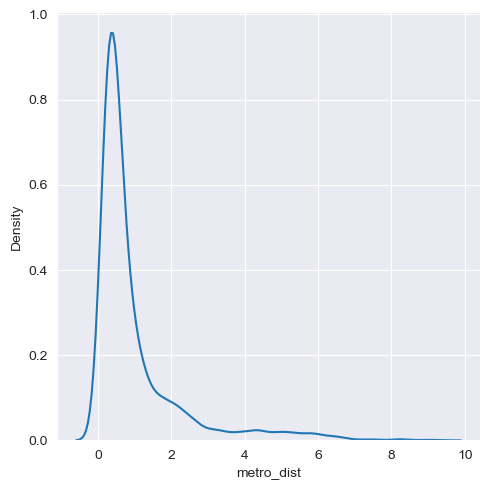

In [391]:
sns.displot(data=london_copy['metro_dist'], kind='kde')
plt.show()

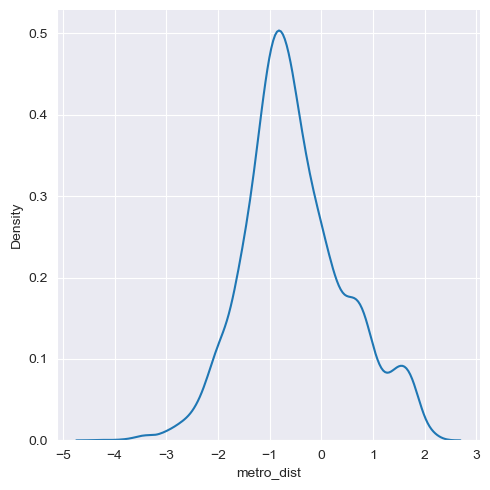

In [612]:
# log-transform for a more 'normal' distribution
sns.displot(data=np.log(london_copy['metro_dist']), kind='kde')
plt.show()

#### 5. Attraction index (normalised)

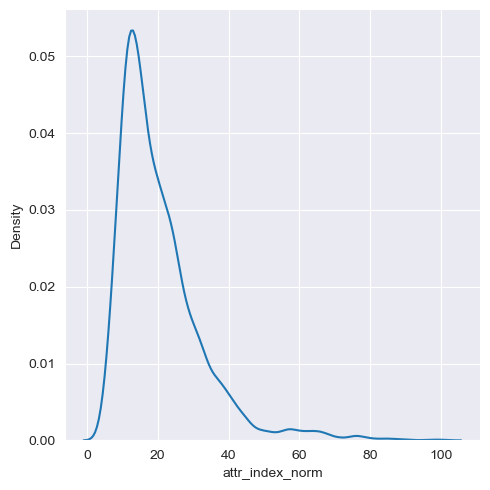

In [392]:
sns.displot(data=london_copy['attr_index_norm'], kind='kde')
plt.show()

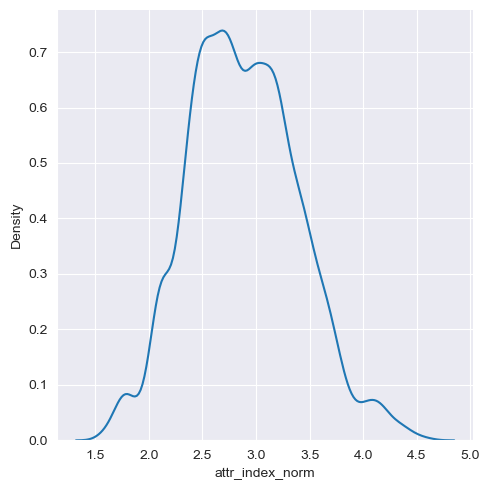

In [613]:
# log-transform for a more 'normal' distribution
sns.displot(data=np.log(london_copy['attr_index_norm']), kind='kde')
plt.show()

#### 6. Restaurant index (normalised)

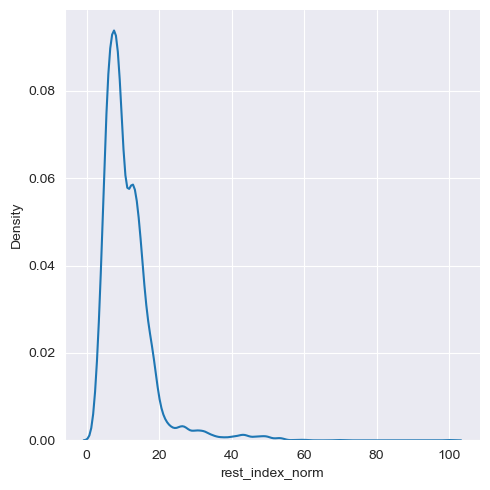

In [625]:
sns.displot(data=london_copy['rest_index_norm'], kind='kde')
plt.show()

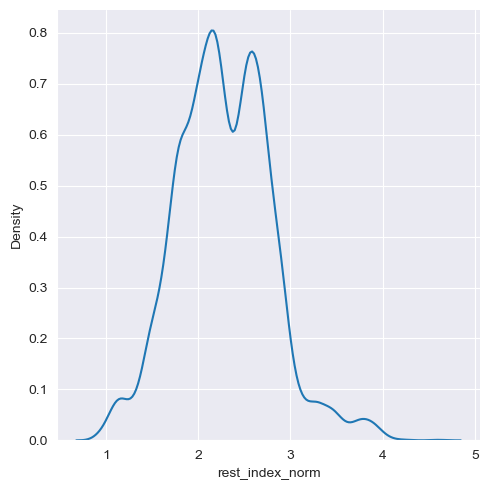

In [614]:
# log-transform for a more 'normal' distribution
sns.displot(data=np.log(london_copy['rest_index_norm']), kind='kde')
plt.show()

### <u>Correlation between variables</u>

In [40]:
# Create new log-transformed columns for 'price', 'metro_dist', 'attr_index_norm' and 'rest_index_norm'
london_copy['price_log'] = np.log(london_copy['price'])
london_copy['metro_dist_log'] = np.log(london_copy['metro_dist'])
london_copy['attr_index_log'] = np.log(london_copy['attr_index_norm'])
london_copy['rest_index_log'] = np.log(london_copy['rest_index_norm'])

# Rearrange columns
london_copy = london_copy[['city',
                           'realSum',
                           'price',
                           'price_log',
                           'room_type',
                           'room_entire_home',
                           'room_shared',
                           'room_private',
                           'person_capacity',
                           'host_is_superhost',
                           'host_type',
                           'single',
                           'multi',
                           'biz',
                           'cleanliness_rating',
                           'guest_satisfaction_overall',
                           'bedrooms',
                           'dist',
                           'metro_dist',
                           'metro_dist_log',
                           'attr_index',
                           'attr_index_norm',
                           'attr_index_log',
                           'rest_index',
                           'rest_index_norm',
                           'rest_index_log',
                           'lng',
                           'lat',
                           'is_weekend']]

london_copy.head()

city     realSum       price  price_log        room_type  \
0  London  570.098074  127.687716   4.849588  Entire home/apt   
1  London  297.984430   66.741063   4.200820     Private room   
2  London  336.790611   75.432677   4.323241     Private room   
3  London  226.722171   50.780098   3.927505     Private room   
4  London  256.355982   57.417331   4.050346     Private room   

   room_entire_home  room_shared  room_private  person_capacity  \
0              True        False         False                2   
1             False        False          True                2   
2             False        False          True                2   
3             False        False          True                2   
4             False        False          True                3   

   host_is_superhost  ... metro_dist_log  attr_index  attr_index_norm  \
0              False  ...       0.463099  209.632578        14.571793   
1               True  ...      -0.969528  553.891744        38.501630   
2              False  ...      -0.791471  428.287849        29.770764   
3               True  ...       0.544634  195.694744        13.602959   
4              False  ...      -0.191866  329.477068        22.902317   

   attr_index_log  rest_index  rest_index_norm  rest_index_log      lng  \
0        2.679088  467.597522         8.372724        2.124979 -0.16032   
1        3.650701  961.472137        17.215961        2.845837 -0.09683   
2        3.393527  959.042839        17.172462        2.843307 -0.10554   
3        2.610287  452.232472         8.097600        2.091568 -0.16575   
4        3.131238  735.327280        13.166649        2.577687 -0.12055   

        lat  is_weekend  
0  51.46531       False  
1  51.50343       False  
2  51.52407       False  
3  51.46292       False  
4  51.53728       False  

[5 rows x 29 columns]

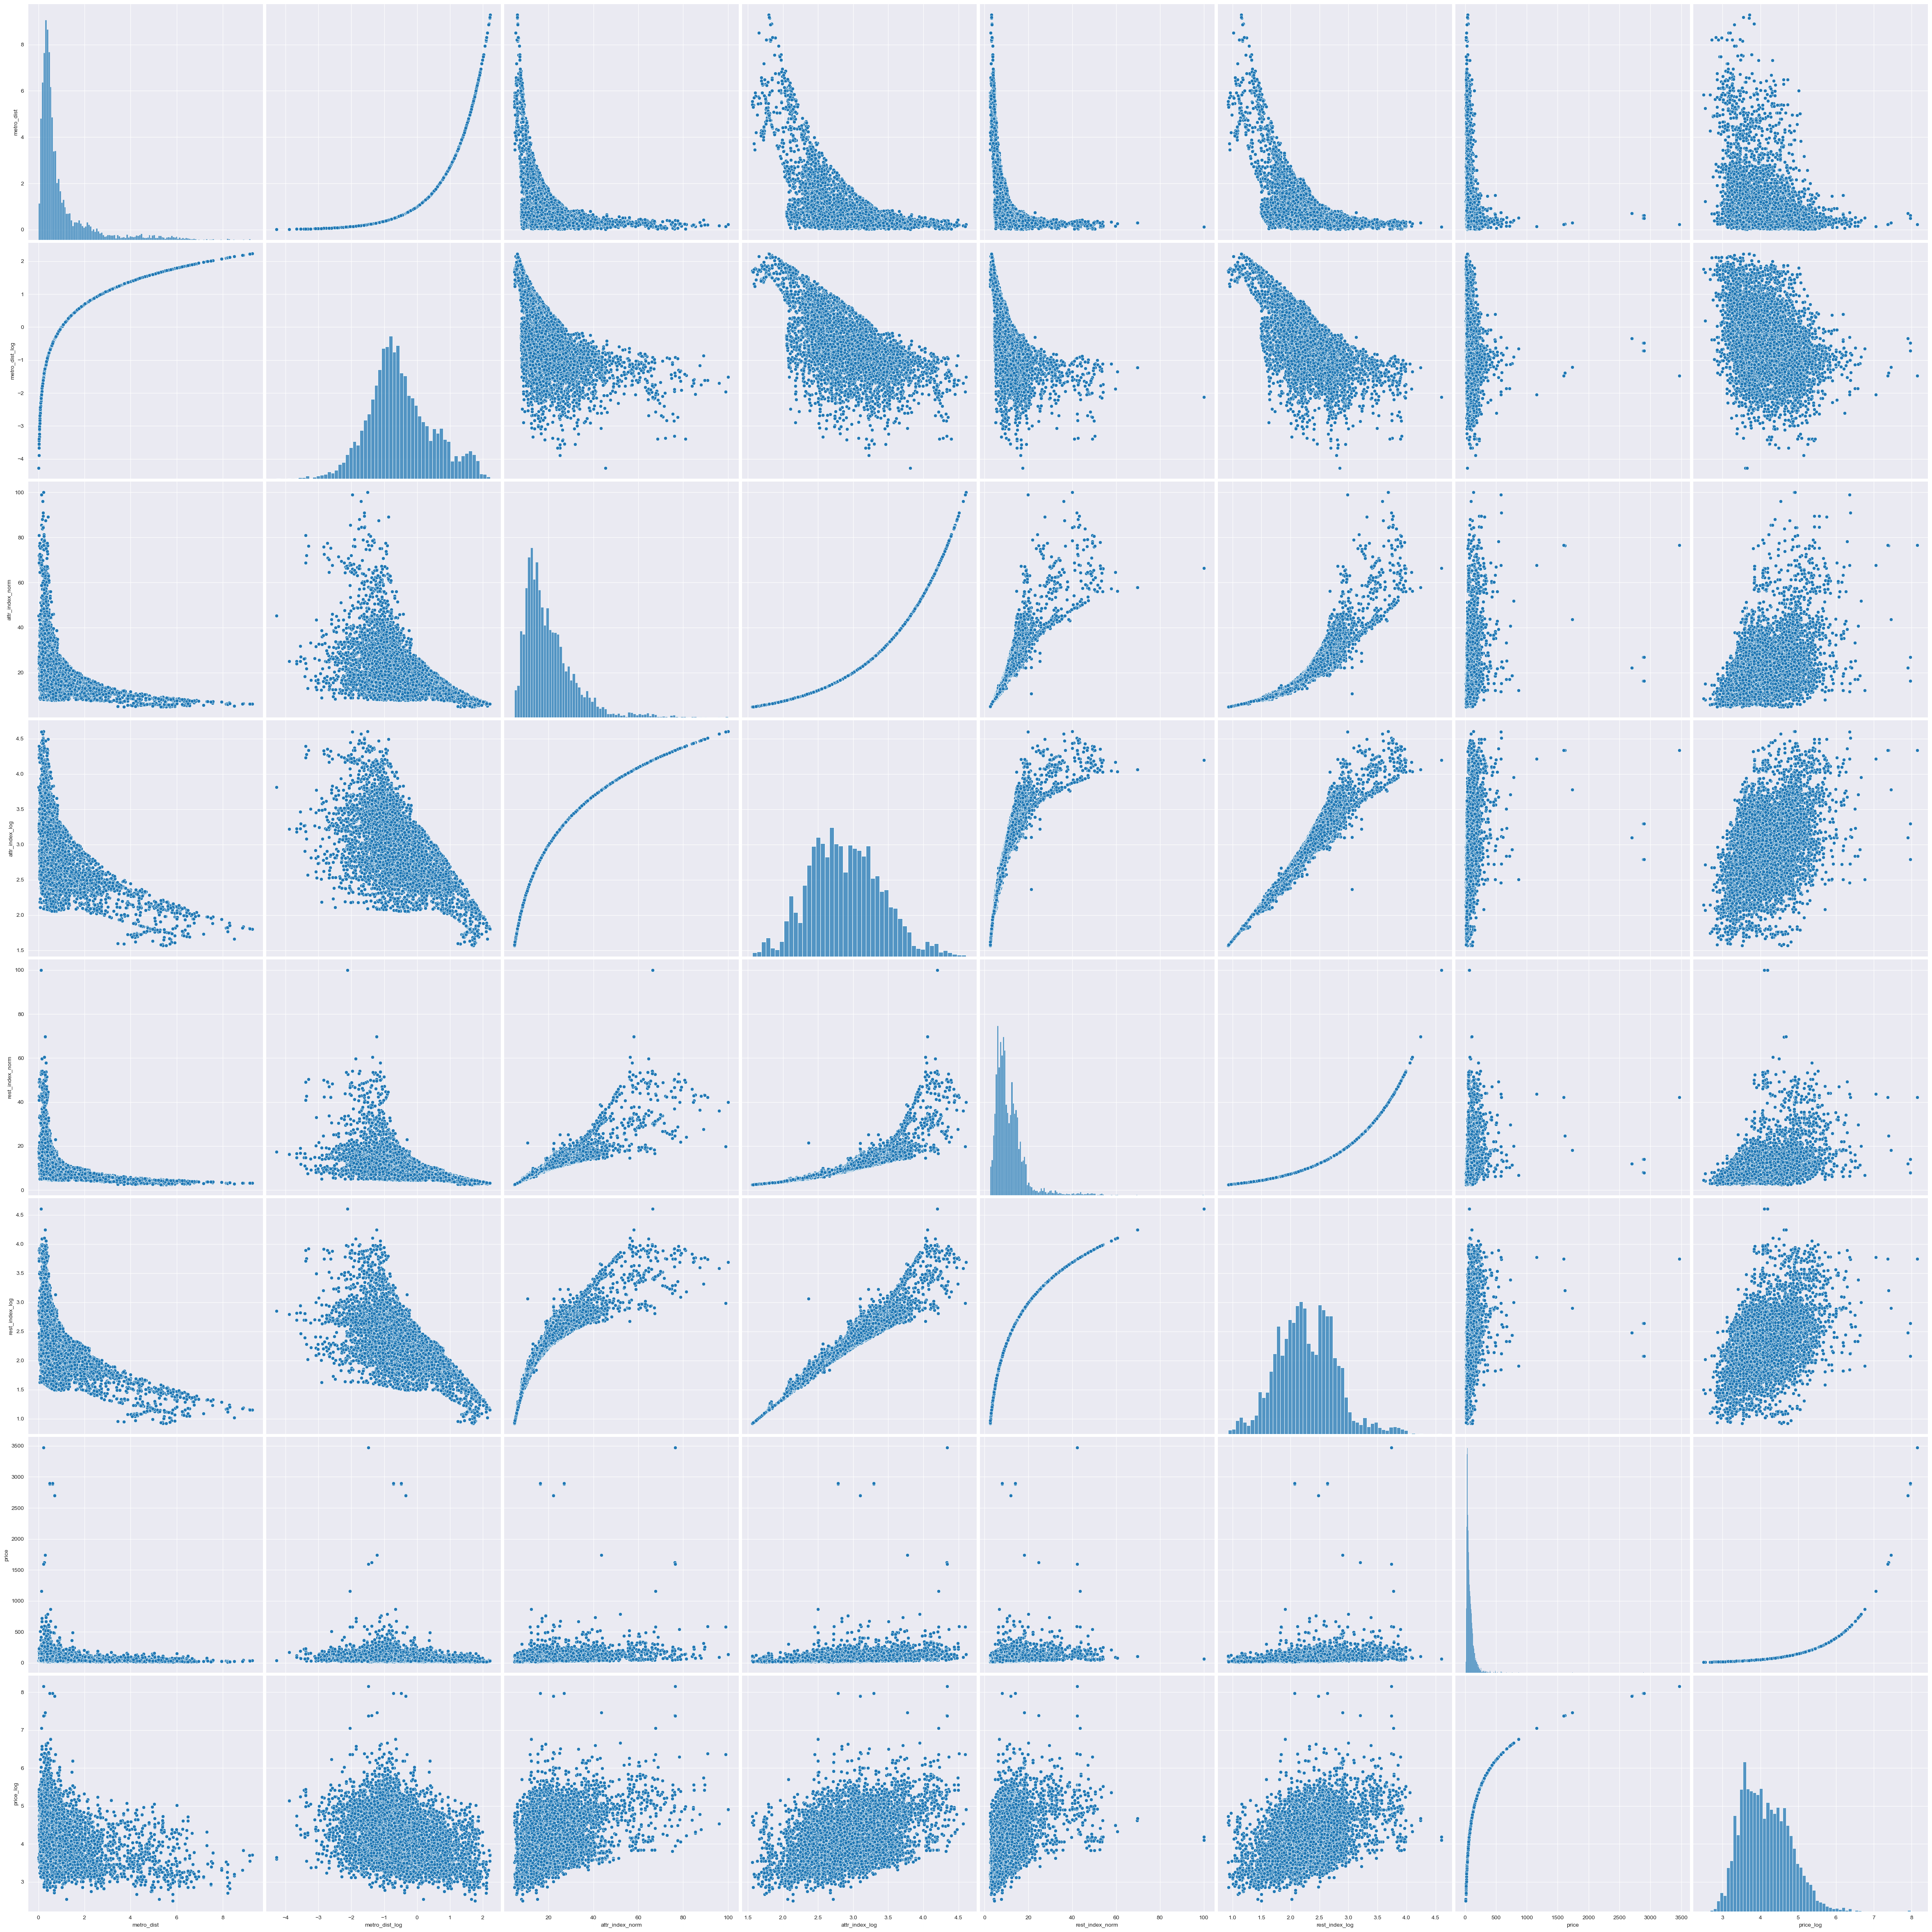

In [341]:
# Create scatter plots to show how the relationship between price and certain independent variables changes after they've been transformed
sns.pairplot(london_copy[['metro_dist', 'metro_dist_log', 'attr_index_norm', 'attr_index_log', 'rest_index_norm', 'rest_index_log', 'price', 'price_log']], height=6)
plt.show()

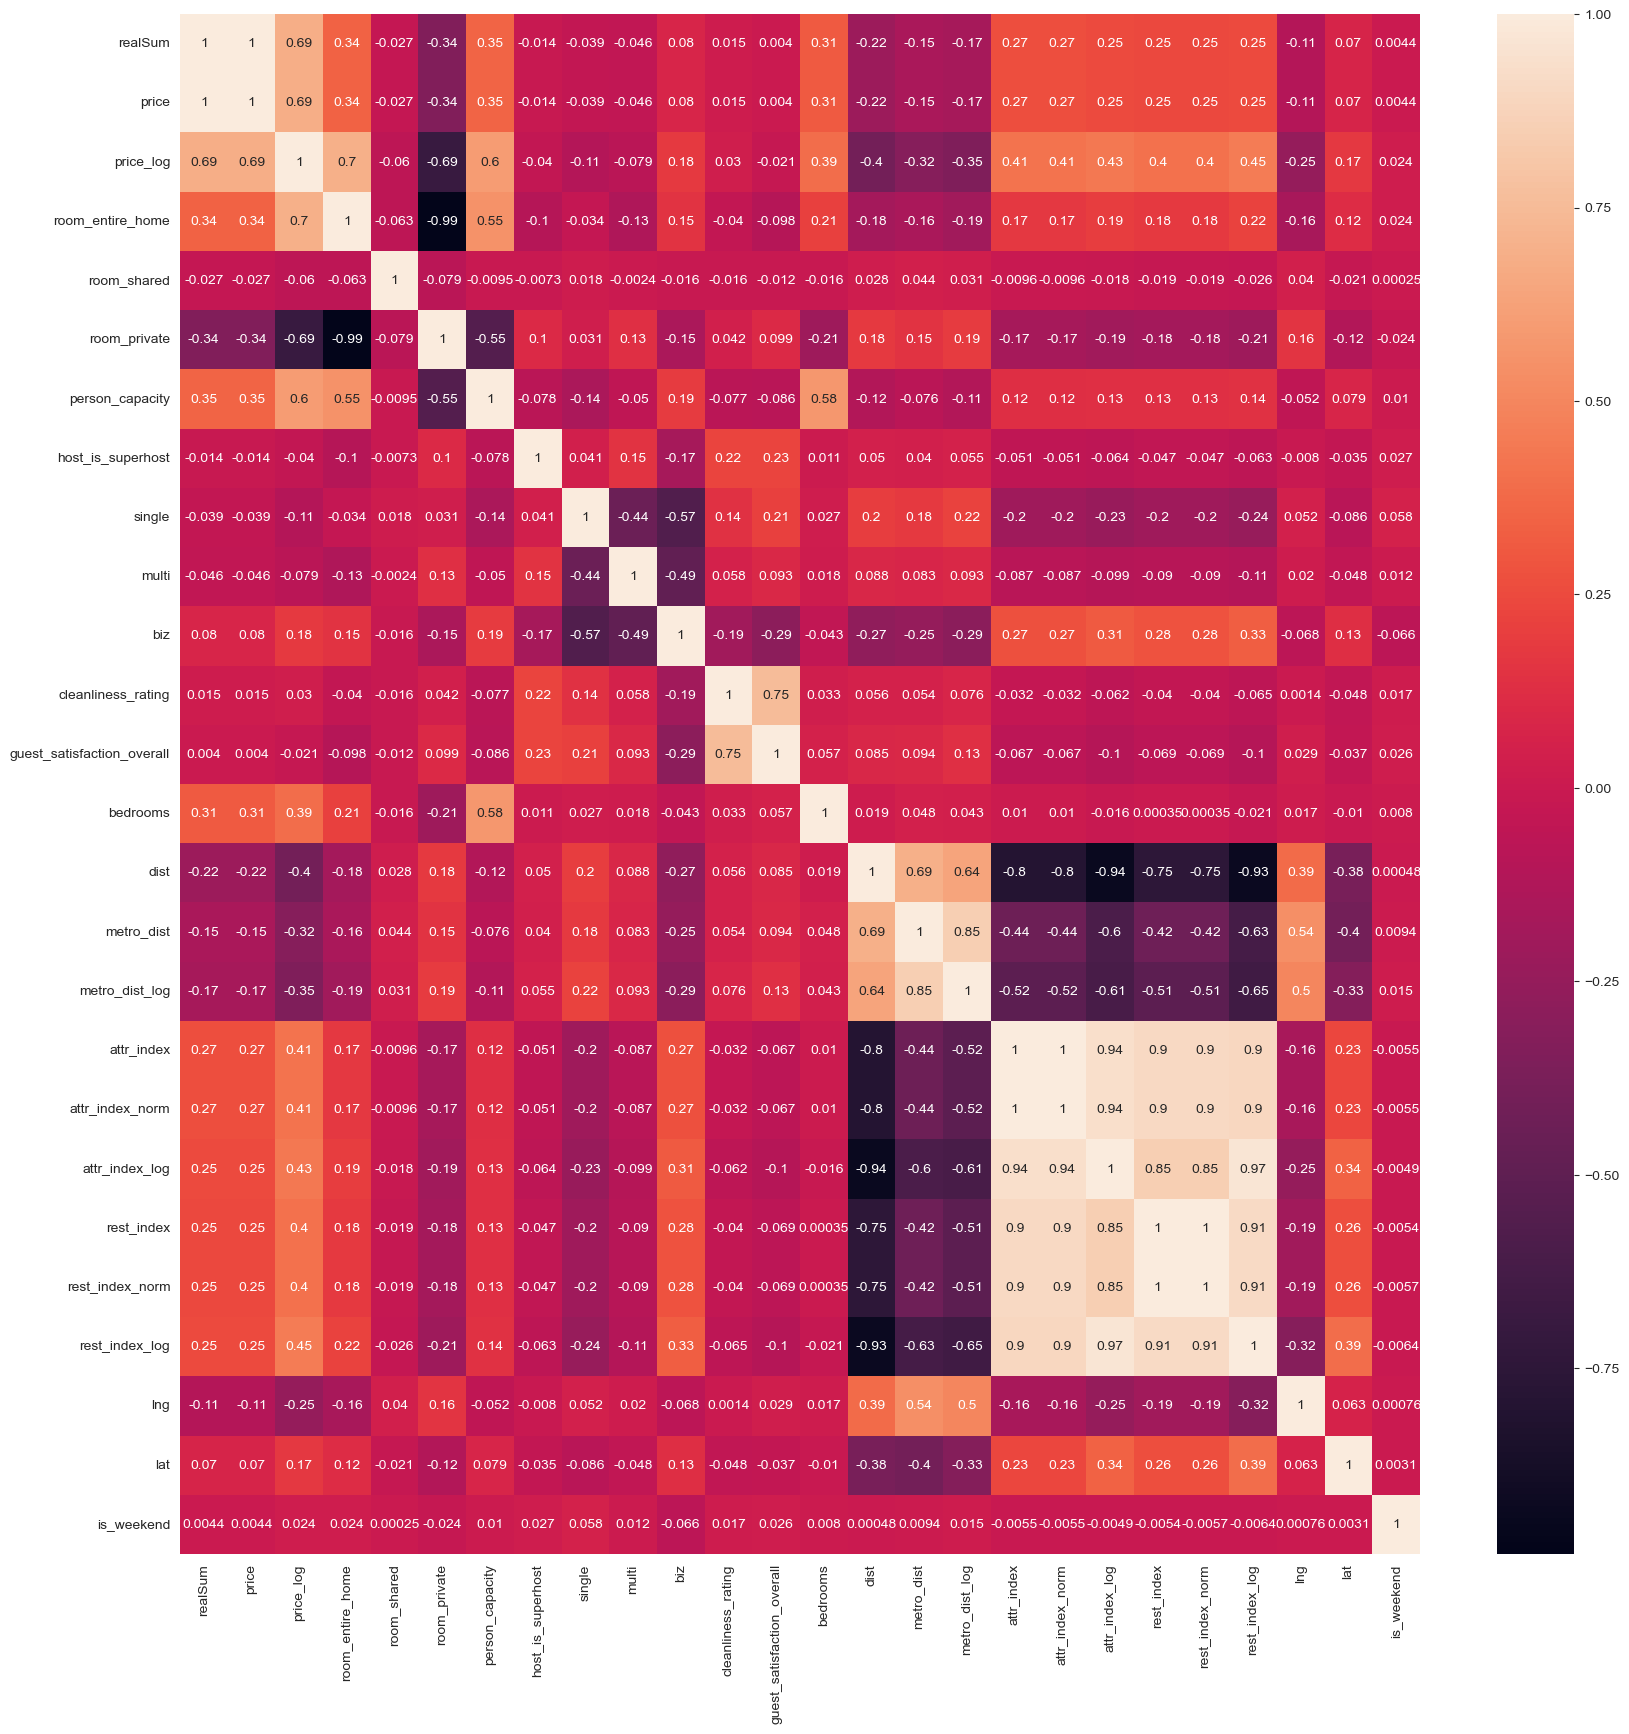

In [42]:
# Create correlation matrix to measure the correlation between the target/log-transformed target and independent variables
plt.figure(figsize=(20,20))
sns.heatmap(data=london_copy.corr(numeric_only=True), cmap='rocket', annot=True)
plt.show()

In [43]:
# Define a function that returns only columns that have either a positive or negative correlation with price
def get_correlated(dataframe, target):
    # Create and define correlation matrix for a given dataframe
    corr_matrix = dataframe.corr(numeric_only=True).loc[target, :]
    # Create a list of columns that are positively or negatively correlated with the target variable
    corr_cols = [corr_matrix.index.values[i] for i in range(0, len(corr_matrix)) if abs(corr_matrix[i]) >= 0.05]
    # Remove target column from the list
    corr_cols.remove(target)
    return corr_cols

In [44]:
get_correlated(london_copy, 'price')

['realSum',
 'price_log',
 'room_entire_home',
 'room_private',
 'person_capacity',
 'biz',
 'bedrooms',
 'dist',
 'metro_dist',
 'metro_dist_log',
 'attr_index',
 'attr_index_norm',
 'attr_index_log',
 'rest_index',
 'rest_index_norm',
 'rest_index_log',
 'lng',
 'lat']

Obviously, we can ignore 'realSum' and 'price_log' as these are just different representations of the target variable, 'price'.
We can also ignore 'attr_index' and 'rest_index' as these are redundant, non-normalised forms of 'attr_index_norm' and 'rest_index_norm' respectively.
We also need to make note of any dummies in this list - if there is a group of n dummies relating to one main variable, then we can only include at most n-1 dummies from this group (where n is the total number of dummies that were created from one-hot encoding) when working with linear regression models to reduce multicollinearity.

In [73]:
# Let's create 2 lists of features to play with, first by identifying which features we don't want in each list
unwanted = ['realSum', 'price_log', 'attr_index', 'rest_index']
orig_cols = ['metro_dist', 'attr_index_norm', 'rest_index_norm']
log_cols = ['metro_dist_log', 'attr_index_log', 'rest_index_log']

# Features with variables that have NOT been log-transformed
features_orig = [col for columns in get_correlated(london_copy, 'price') if col not in unwanted and col not in log_cols]
print(features_orig)

# Features with variables that HAVE been log-transformed
features_log = [col for columns in get_correlated(london_copy, 'price') if col not in unwanted and col not in orig_cols]
print(features_log)

['room_entire_home', 'room_private', 'person_capacity', 'biz', 'bedrooms', 'dist', 'metro_dist', 'attr_index_norm', 'rest_index_norm', 'lng', 'lat']
['room_entire_home', 'room_private', 'person_capacity', 'biz', 'bedrooms', 'dist', 'metro_dist_log', 'attr_index_log', 'rest_index_log', 'lng', 'lat']


## 2. Modelling

### <u>Linear Regression</u>

In [75]:
# Create a feature engineering function
def feature_eng(df, model):
    # Linear regression requirements
    if model == 'lin_reg':
        df = sm.add_constant(df)
    # Change boolean values to binary
    for column in list(df.columns):
        if df[column].dtypes == bool:
            df[column] = df[column].map({True:1, False:0})

    return df

In [111]:
# Define feature and target variables for each combination we can train the model with
# Comment in and out each combination when necessary to obtain different results

# COMBO 1
# X = london_copy[features_orig]
# y = london_copy['price']

# # COMBO 2
# X = london_copy[features_log]
# y = london_copy['price']

# # COMBO 3
X = london_copy[features_orig]
y = london_copy['price_log']

# COMBO 4
# X = london_copy[features_log]
# y = london_copy['price_log']

# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
# Apply changes to training data
X_train = feature_eng(df=X_train, model='lin_reg')

In [102]:
X_train.head()

const  room_entire_home  room_private  person_capacity  biz  bedrooms  \
4098    1.0                 1             0                2    1         1   
3535    1.0                 1             0                6    1         2   
3497    1.0                 1             0                4    0         1   
1238    1.0                 0             1                2    1         1   
168     1.0                 0             1                2    0         1   

          dist  metro_dist_log  attr_index_log  rest_index_log      lng  \
4098  2.396231       -1.700486        3.451293        2.927506 -0.16096   
3535  4.356985       -0.178461        3.054197        2.578113 -0.07000   
3497  3.117578       -1.573933        3.252811        2.663354 -0.16690   
1238  1.859059       -2.125523        3.557089        3.052984 -0.13724   
168   3.751229        0.069703        3.124291        2.494123 -0.16713   

           lat  
4098  51.51363  
3535  51.52400  
3497  51.52178  
1238  51.52389  
168   51.48541

In [104]:
# Initialise and fit linear regression model to training data
lin_reg = sm.OLS(y_train, X_train)
results = lin_reg.fit()

# Display summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     1542.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:46:09   Log-Likelihood:                -3308.2
No. Observations:                7994   AIC:                             6640.
Df Residuals:                    7982   BIC:                             6724.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.1314      8.092     -0.511      0.610     -19.994      11.731
room_entire_home     0.8743      0.059     14.763      0.000       0.758       0.990
room_private         0.2506      0.059      4.249      0.000       0.135       0.366
person_capacity      0.0965      0.005     19.776      0.000       0.087       0.106
biz                 -0.0521      0.009     -5.634      0.000      -0.070      -0.034
bedrooms             0.2046      0.009     22.718      0.000       0.187       0.222
dist                 0.0483      0.005      8.935      0.000       0.038       0.059
metro_dist_log      -0.0155      0.006     -2.466      0.014      -0.028      -0.003
attr_index_log       0.3489      0.040      8.722      0.000       0.270       0.427
rest_index_log       0.2730      0.035      7.738      0.000       0.204       0.342
lng                 -0.8759      0.085    -10.254      0.000      -1.043      -0.708
lat                  0.1023      0.157      0.654      0.513      -0.205       0.409
==============================================================================
Omnibus:                     3738.588   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50548.828
Skew:                           1.890   Prob(JB):                         0.00
Kurtosis:                      14.725   Cond. No.                     1.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
# Now it's time for K-fold cross-validation to train the model
# The linear regression model initialised from statsmodel is incompatible with the cross_val_score method from sklearn

# To get around this, the model must be 'wrapped' as follows to appear like an sklearn model:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [80]:
# K-fold cross-validation results for COMBO 1
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {abs(lr_scores)}')
print(f'The mean of the scores is: {stats.mean(abs(lr_scores))}')
print(f'The standard deviation of scores is: {stats.stdev(abs(lr_scores))}')

The scores are: [ 46.5577286   44.79423468 131.57320555  49.00725235  50.29961445
 171.98786251  98.94069897  52.45334964  45.82721561 110.63686327]
The mean of the scores is: 80.20780256442339
The standard deviation of scores is: 45.39406459645865


In [84]:
# K-fold cross-validation results for COMBO 2
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {abs(lr_scores)}')
print(f'The mean of the scores is: {stats.mean(abs(lr_scores))}')
print(f'The standard deviation of scores is: {stats.stdev(abs(lr_scores))}')

The scores are: [ 46.42269198  44.34577937 132.00190206  49.19801305  50.27575504
 171.77785239  98.50923904  52.91977716  45.65032839 110.52087185]
The mean of the scores is: 80.16222103145942
The standard deviation of scores is: 45.39385054946288


In [99]:
# K-fold cross-validation results for COMBO 3
# Remember, we need to convert the results BACK to the original units (GBP) since we log-transformed the target
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {np.exp(abs(lr_scores))}')
print(f'The mean of the scores is: {stats.mean(np.exp(abs(lr_scores)))}')
print(f'The standard deviation of scores is: {stats.stdev(np.exp(abs(lr_scores)))}')

The scores are: [1.40962516 1.42523141 1.47281384 1.45242527 1.43787599 1.50061732
 1.4452181  1.43529206 1.43223811 1.45278607]
The mean of the scores is: 1.4464123337946755
The standard deviation of scores is: 0.025631561001422234


In [105]:
# K-fold cross-validation results for COMBO 4
# Remember, we need to convert the results BACK to the original units (GBP) since we log-transformed the target
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {np.exp(abs(lr_scores))}')
print(f'The mean of the scores is: {stats.mean(np.exp(abs(lr_scores)))}')
print(f'The standard deviation of scores is: {stats.stdev(np.exp(abs(lr_scores)))}')

The scores are: [1.40927371 1.41666702 1.4702129  1.44903184 1.43482365 1.49408186
 1.44129003 1.43534664 1.42624615 1.4469266 ]
The mean of the scores is: 1.4423900404358718
The standard deviation of scores is: 0.02502867206192429


Based on these results, let's move forward with Combos 3 and 4 respectively - looks like log-transformations on the target and selected features are beneficial.

#### <u>Feature selection for model improvement</u>

In [106]:
# Define function which returns features with the least amount of multicollinearity
def calculate_vif(X, thresh = 5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        # this bit uses list comprehension to gather all the VIF values of the different variables
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif)) # getting the index of the highest VIF value
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc] # we delete the highest VIF value on condition that it's higher than the threshold
            dropped = True # if we deleted anything, we set the 'dropped' value to True to stay in the while loop

    print('Remaining variables:')
    print(X.columns[variables]) # finally, we print the variables that are still in our set
    return X.iloc[:, variables] # and return our X cut down to the remaining variables

In [113]:
# Get the results for the original list of features
multicol_orig = list(calculate_vif(X_train[features_orig]).columns)
print(multicol_orig)

dropping 'lat' at index: 10
dropping 'attr_index_norm' at index: 7
dropping 'room_private' at index: 1
dropping 'person_capacity' at index: 1
dropping 'dist' at index: 3
Remaining variables:
Index(['room_entire_home', 'biz', 'bedrooms', 'metro_dist', 'rest_index_norm',
       'lng'],
      dtype='object')
['room_entire_home', 'biz', 'bedrooms', 'metro_dist', 'rest_index_norm', 'lng']


In [108]:
# Get the results for the feature list containing log-transformed columns
multicol_log = list(calculate_vif(X_train[features_log]).columns)
print(multicol_log)

dropping 'lat' at index: 10
dropping 'attr_index_log' at index: 7
dropping 'rest_index_log' at index: 7
dropping 'person_capacity' at index: 2
dropping 'room_private' at index: 1
Remaining variables:
Index(['room_entire_home', 'biz', 'bedrooms', 'dist', 'metro_dist_log', 'lng'], dtype='object')
['room_entire_home', 'biz', 'bedrooms', 'dist', 'metro_dist_log', 'lng']


In [109]:
# Check columns for statistical significance
def stepwise_selection(X, y, threshold_in = 0.01, threshold_out = 0.05, verbose = True):
    # The function is checking for p-values (whether features are statistically significant), the lower the better
    included = [] # this is going to be the list of features we keep
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index = excluded, dtype = 'float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        # we add the feature with the lowest (best) p-value under the threshold to our 'included' list
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) # specifying the verbose text

        # backward step: removing features if new features added to the list make them statistically insignificant
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()

        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        # if the p-value exceeds the upper threshold, the feature will be dropped from the 'included' list
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [114]:
# Get the results for the original list of features
stepwise_orig = stepwise_selection(X_train[features_orig], y_train)
print(stepwise_orig)

Add  dist                           with p-value 0.0
Add  room_entire_home               with p-value 0.0
Add  bedrooms                       with p-value 6.40172e-300
Add  person_capacity                with p-value 1.34472e-81
Add  attr_index_norm                with p-value 4.07407e-59
Add  lng                            with p-value 1.95663e-33
Add  metro_dist                     with p-value 8.81944e-13
Add  room_private                   with p-value 3.02152e-05
Add  biz                            with p-value 0.000544662
Add  rest_index_norm                with p-value 0.00620477
['dist', 'room_entire_home', 'bedrooms', 'person_capacity', 'attr_index_norm', 'lng', 'metro_dist', 'room_private', 'biz', 'rest_index_norm']


In [110]:
# Get the results for the feature list containing log-transformed columns
stepwise_log = stepwise_selection(X_train[features_log], y_train)
print(stepwise_log)

Add  dist                           with p-value 0.0
Add  room_entire_home               with p-value 0.0
Add  bedrooms                       with p-value 6.40172e-300
Add  rest_index_log                 with p-value 2.67309e-94
Add  person_capacity                with p-value 3.76888e-73
Add  lng                            with p-value 9.33237e-24
Add  attr_index_log                 with p-value 4.27014e-18
Add  biz                            with p-value 1.21354e-07
Add  room_private                   with p-value 1.81018e-05
Add  metro_dist_log                 with p-value 0.00709216
['dist', 'room_entire_home', 'bedrooms', 'rest_index_log', 'person_capacity', 'lng', 'attr_index_log', 'biz', 'room_private', 'metro_dist_log']


In [115]:
# Return features that are both statistically significant AND lack multicollinearity
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [116]:
features_orig_int = intersection(multicol_orig, stepwise_orig)
print(features_orig_int)

['room_entire_home', 'biz', 'rest_index_norm', 'bedrooms', 'metro_dist', 'lng']


In [117]:
features_log_int = intersection(multicol_log, stepwise_log)
print(features_log_int)

['dist', 'room_entire_home', 'biz', 'metro_dist_log', 'bedrooms', 'lng']


In [123]:
# Use these new list of features for a new round of training

# # COMBO 1
# X = london_copy[features_orig_int]
# y = london_copy['price_log']

# COMBO 2
X = london_copy[features_log_int]
y = london_copy['price_log']

# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply changes to training data
X_train = feature_eng(df=X_train, model='lin_reg')

In [124]:
X_train.head()

const      dist  room_entire_home  biz  metro_dist_log  bedrooms  \
4098    1.0  2.396231                 1    1       -1.700486         1   
3535    1.0  4.356985                 1    1       -0.178461         2   
3497    1.0  3.117578                 1    0       -1.573933         1   
1238    1.0  1.859059                 0    1       -2.125523         1   
168     1.0  3.751229                 0    0        0.069703         1   

          lng  
4098 -0.16096  
3535 -0.07000  
3497 -0.16690  
1238 -0.13724  
168  -0.16713

In [126]:
# Initialise and fit linear regression model to training data
lin_reg = sm.OLS(y_train, X_train)
results = lin_reg.fit()

# Display summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     2399.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:17:40   Log-Likelihood:                -3744.5
No. Observations:                7994   AIC:                             7503.
Df Residuals:                    7987   BIC:                             7552.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.7241      0.019    193.749      0.000       3.686       3.762
dist                -0.0588      0.002    -28.056      0.000      -0.063      -0.055
room_entire_home     0.7522      0.009     81.576      0.000       0.734       0.770
biz                  0.0146      0.009      1.546      0.122      -0.004       0.033
metro_dist_log      -0.0507      0.006     -8.087      0.000      -0.063      -0.038
bedrooms             0.3062      0.008     39.547      0.000       0.291       0.321
lng                 -0.2091      0.074     -2.810      0.005      -0.355      -0.063
==============================================================================
Omnibus:                     3213.428   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33615.343
Skew:                           1.632   Prob(JB):                         0.00
Kurtosis:                      12.501   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
# K-fold cross-validation results for COMBO 1
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {np.exp(abs(lr_scores))}')
print(f'The mean of the scores is: {stats.mean(np.exp(abs(lr_scores)))}')
print(f'The standard deviation of scores is: {stats.stdev(np.exp(abs(lr_scores)))}')

The scores are: [1.42708773 1.43643045 1.49679917 1.46903937 1.45438845 1.52528144
 1.45663965 1.47355438 1.45015343 1.47534604]
The mean of the scores is: 1.466472011045664
The standard deviation of scores is: 0.028822032923657655


In [127]:
# K-fold cross-validation results for for COMBO 2
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {np.exp(abs(lr_scores))}')
print(f'The mean of the scores is: {stats.mean(np.exp(abs(lr_scores)))}')
print(f'The standard deviation of scores is: {stats.stdev(np.exp(abs(lr_scores)))}')

The scores are: [1.43246062 1.43459421 1.50188217 1.47912189 1.46160007 1.52045866
 1.46684122 1.47264671 1.4625738  1.48665518]
The mean of the scores is: 1.4718834541946626
The standard deviation of scores is: 0.027270544238031658


In both cases, we saw a slight reduction in performance - indicating that the model isn't as robust as we thought. We also observed that 'biz' was found to be statistically insignificant in each case (with p-values of 0.499 and 0.122 respectively), indicating that the number of listings a host owns bears no influence on the price of one of their listings.

In [129]:
# Remove 'biz' from both feature lists
features_orig_int_2 = features_orig_int.copy()
features_orig_int_2.remove('biz')
print(features_orig_int_2)

features_log_int_2 = features_log_int.copy()
features_log_int_2.remove('biz')
print(features_log_int_2)

['room_entire_home', 'rest_index_norm', 'bedrooms', 'metro_dist', 'lng']
['dist', 'room_entire_home', 'metro_dist_log', 'bedrooms', 'lng']


In [135]:
# Select these features for a new round of training
# Comment in and out each combination when necessary to obtain different results

# # COMBO 1
# X = london_copy[features_orig_int_2]
# y = london_copy['price_log']

# COMBO 2
X = london_copy[features_log_int_2]
y = london_copy['price_log']

# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply changes to training data
X_train = feature_eng(df=X_train, model='lin_reg')

In [136]:
X_train.head()

const      dist  room_entire_home  metro_dist_log  bedrooms      lng
4098    1.0  2.396231                 1       -1.700486         1 -0.16096
3535    1.0  4.356985                 1       -0.178461         2 -0.07000
3497    1.0  3.117578                 1       -1.573933         1 -0.16690
1238    1.0  1.859059                 0       -2.125523         1 -0.13724
168     1.0  3.751229                 0        0.069703         1 -0.16713

In [138]:
# Initialise and fit linear regression model to training data
lin_reg = sm.OLS(y_train, X_train)
results = lin_reg.fit()

# Display summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     2877.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:50:05   Log-Likelihood:                -3745.7
No. Observations:                7994   AIC:                             7503.
Df Residuals:                    7988   BIC:                             7545.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.7324      0.018    202.109      0.000       3.696       3.769
dist                -0.0592      0.002    -28.403      0.000      -0.063      -0.055
room_entire_home     0.7538      0.009     82.290      0.000       0.736       0.772
metro_dist_log      -0.0525      0.006     -8.524      0.000      -0.065      -0.040
bedrooms             0.3055      0.008     39.520      0.000       0.290       0.321
lng                 -0.1960      0.074     -2.651      0.008      -0.341      -0.051
==============================================================================
Omnibus:                     3201.368   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33201.540
Skew:                           1.627   Prob(JB):                         0.00
Kurtosis:                      12.439   Cond. No.                         106.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
# K-fold cross-validation results for COMBO 1
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {np.exp(abs(lr_scores))}')
print(f'The mean of the scores is: {stats.mean(np.exp(abs(lr_scores)))}')
print(f'The standard deviation of scores is: {stats.stdev(np.exp(abs(lr_scores)))}')

The scores are: [1.42703872 1.43647614 1.49677003 1.46912343 1.45424654 1.52534196
 1.4567031  1.47359137 1.44998002 1.4753796 ]
The mean of the scores is: 1.4664650917766338
The standard deviation of scores is: 0.0288527240861377


In [139]:
# K-fold cross-validation results for COMBO 2
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {np.exp(abs(lr_scores))}')
print(f'The mean of the scores is: {stats.mean(np.exp(abs(lr_scores)))}')
print(f'The standard deviation of scores is: {stats.stdev(np.exp(abs(lr_scores)))}')

The scores are: [1.43246712 1.43457821 1.50190543 1.47951964 1.4615172  1.52060382
 1.4668986  1.47262156 1.4624752  1.48686148]
The mean of the scores is: 1.4719448274310614
The standard deviation of scores is: 0.027333950372858403


#### Standardise the features for better performance?

In [ ]:
# Define feature and target variables for each combination we can train the model with
# Comment in and out each combination (and their respective scalers) when necessary to obtain different results

# COMBO 1
# X = london_copy[features_orig_int_2]
# y = london_copy['price_log']

# COMBO 2
X = london_copy[features_log_int_2]
y = london_copy['price_log']

# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply changes to training data
X_train = feature_eng(df=X_train, model='lin_reg')

# Create column transformers for each combination
# col_transformer = ColumnTransformer(verbose = True, transformers = [('ss', StandardScaler(), features_orig_int_2)]) # for COMBO 1
col_transformer = ColumnTransformer(verbose = True, transformers = [('ss', StandardScaler(), features_log_int_2)]) # for COMBO 2

# Standardise the data
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

In [154]:
X_train[0:5]

array([[-1.07668769,  1.12625261, -1.21581547, -0.22093866, -0.68246226],
       [-0.3555215 ,  1.12625261,  0.33907625,  1.51914372,  0.65694238],
       [-0.81137615,  1.12625261, -1.08653044, -0.22093866, -0.76992998],
       [-1.27425988, -0.88790027, -1.6500316 , -0.22093866, -0.3331804 ],
       [-0.57831894, -0.88790027,  0.59259872, -0.22093866, -0.77331677]])

In [156]:
# Initialise and fit linear regression model to training data
lin_reg = sm.OLS(y_train, X_train)
results = lin_reg.fit()

# Display summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              24.84
Date:                Thu, 30 Mar 2023   Prob (F-statistic):                    6.44e-25
Time:                        00:31:53   Log-Likelihood:                         -22741.
No. Observations:                7994   AIC:                                  4.549e+04
Df Residuals:                    7989   BIC:                                  4.553e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1608      0.061     -2.639      0.008      -0.280      -0.041
x2             0.3743      0.049      7.645      0.000       0.278       0.470
x3            -0.0514      0.065     -0.792      0.428      -0.179       0.076
x4             0.1756      0.048      3.672      0.000       0.082       0.269
x5            -0.0133      0.054     -0.246      0.805      -0.119       0.093
==============================================================================
Omnibus:                     3201.368   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33201.540
Skew:                           1.627   Prob(JB):                         0.00
Kurtosis:                      12.439   Cond. No.                         2.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [150]:
# K-fold cross-validation results for COMBO 1
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {np.exp(abs(lr_scores))}')
print(f'The mean of the scores is: {stats.mean(np.exp(abs(lr_scores)))}')
print(f'The standard deviation of scores is: {stats.stdev(np.exp(abs(lr_scores)))}')

The scores are: [1.42703872 1.43647614 1.49677003 1.46912343 1.45424654 1.52534196
 1.4567031  1.47359137 1.44998002 1.4753796 ]
The mean of the scores is: 1.4664650917766338
The standard deviation of scores is: 0.028852724086137538


In [158]:
# K-fold cross-validation results for COMBO 2
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {np.exp(abs(lr_scores))}')
print(f'The mean of the scores is: {stats.mean(np.exp(abs(lr_scores)))}')
print(f'The standard deviation of scores is: {stats.stdev(np.exp(abs(lr_scores)))}')

The scores are: [1.43246712 1.43457821 1.50190543 1.47951964 1.4615172  1.52060382
 1.4668986  1.47262156 1.4624752  1.48686148]
The mean of the scores is: 1.4719448274310616
The standard deviation of scores is: 0.02733395037285809


Standard scaling hasn't made a difference, but in both cases the model highlighted that the longitudinal coordinate of a listing and its distance from its nearest metro station aren't likely to have much of an effect on the listing's price.

Both 'metro_dist' (distance from metro station) and 'lng' (longitudinal coordinate) were found to be statistically insignificant in both cases, so we can remove them from each feature list.

In [160]:
features_orig_int_3 = features_orig_int_2.copy()
features_orig_int_3.remove('metro_dist')
features_orig_int_3.remove('lng')
print(features_orig_int_3)

features_log_int_3 = features_log_int_2.copy()
features_log_int_3.remove('metro_dist_log')
features_log_int_3.remove('lng')
print(features_log_int_3)

['room_entire_home', 'rest_index_norm', 'bedrooms']
['dist', 'room_entire_home', 'bedrooms']


In [ ]:
# Define feature and target variables for each combination we can train the model with
# Comment in and out each combination when necessary to obtain different results

# COMBO 1
# X = london_copy[features_orig_int_3]
# y = london_copy['price_log']

# COMBO 2
X = london_copy[features_log_int_3]
y = london_copy['price_log']

# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply changes to training data
X_train = feature_eng(df=X_train, model='lin_reg')

# Create column transformers for each combination
# col_transformer = ColumnTransformer(verbose = True, transformers = [('ss', StandardScaler(), features_orig_int_3)]) # for COMBO 1
col_transformer = ColumnTransformer(verbose = True, transformers = [('ss', StandardScaler(), features_log_int_3)]) # for COMBO 2

# Standardise the data
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

In [165]:
# Initialise and fit linear regression model to training data
lin_reg = sm.OLS(y_train, X_train)
results = lin_reg.fit()

# Display summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              41.09
Date:                Thu, 30 Mar 2023   Prob (F-statistic):                    2.43e-26
Time:                        00:59:34   Log-Likelihood:                         -22742.
No. Observations:                7994   AIC:                                  4.549e+04
Df Residuals:                    7991   BIC:                                  4.551e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1976      0.047     -4.165      0.000      -0.291      -0.105
x2             0.3802      0.049      7.834      0.000       0.285       0.475
x3             0.1725      0.048      3.616      0.000       0.079       0.266
==============================================================================
Omnibus:                     3144.900   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31507.015
Skew:                           1.602   Prob(JB):                         0.00
Kurtosis:                      12.183   Cond. No.                         1.34
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
# K-fold cross-validation results for COMBO 1
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {np.exp(abs(lr_scores))}')
print(f'The mean of the scores is: {stats.mean(np.exp(abs(lr_scores)))}')
print(f'The standard deviation of scores is: {stats.stdev(np.exp(abs(lr_scores)))}')

The scores are: [1.44663032 1.44799767 1.50643962 1.48755753 1.46727055 1.54247804
 1.473027   1.48931925 1.45582238 1.48595903]
The mean of the scores is: 1.4802501391784224
The standard deviation of scores is: 0.02927705180314561


In [166]:
# K-fold cross-validation results for COMBO 2
lr_scores = cross_val_score(SMWrapper(sm.OLS), X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
print(f'The scores are: {np.exp(abs(lr_scores))}')
print(f'The mean of the scores is: {stats.mean(np.exp(abs(lr_scores)))}')
print(f'The standard deviation of scores is: {stats.stdev(np.exp(abs(lr_scores)))}')

The scores are: [1.43705367 1.43895152 1.50358192 1.48523332 1.46538962 1.52397677
 1.47250266 1.4766544  1.46552562 1.48879199]
The mean of the scores is: 1.4757661491405325
The standard deviation of scores is: 0.026739971227148912


Ultimately, standardising the data made little improvement on model performance.

### <u>Decision Tree</u>

In [272]:
# Unlike linear regression, decision tree algorithms are non-parametric so the requirement to minimise multicollinearity between features isn't necessary
# Therefore, let's include the other dummies for previously encoded variables that weren't included during linear regression modelling

features2_orig = ['room_entire_home', 'room_private', 'room_shared', 'person_capacity', 'biz', 'multi', 'single', 'bedrooms', 'dist', 'metro_dist', 'attr_index_norm', 'rest_index_norm', 'lng', 'lat']
features2_log = ['room_entire_home', 'room_private', 'room_shared', 'person_capacity', 'biz', 'multi', 'single', 'bedrooms', 'dist', 'metro_dist_log', 'attr_index_log', 'rest_index_log', 'lng', 'lat']

In [285]:
# Define feature and target variables for each combination we can train the model with
# Comment in and out each combination when necessary to obtain different results

# COMBO 1
# X = london_copy[features2_orig]
# y = london_copy['price']

# COMBO 2
# X = london_copy[features2_log]
# y = london_copy['price']

# # COMBO 3
# X = london_copy[features2_orig]
# y = london_copy['price_log']

# COMBO 4
X = london_copy[features2_log]
y = london_copy['price_log']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [286]:
# Initialise and fit model to training data
dt = DecisionTreeRegressor(max_depth=5, random_state=10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=10)

In [275]:
# K-fold cross-validation results for COMBO 1
dt_scores = abs(cross_val_score(dt, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {dt_scores}')
print(f'The mean of the scores is: {stats.mean(dt_scores)}')
print(f'The standard deviation of the scores is: {stats.stdev(dt_scores)}')

The scores are: [ 95.8004904   63.80565415 117.73580896 103.75986845  61.41650368
 165.3581063  133.94087018  52.99223541  53.82392691 119.39352174]
The mean of the scores is: 96.80269861827252
The standard deviation of the scores is: 38.274671025543554


In [279]:
# K-fold cross-validation results for COMBO 2
dt_scores = abs(cross_val_score(dt, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {dt_scores}')
print(f'The mean of the scores is: {stats.mean(dt_scores)}')
print(f'The standard deviation of the scores is: {stats.stdev(dt_scores)}')

The scores are: [ 95.8004904   63.80565415 117.73580896 103.75986845  61.41650368
 165.3581063  133.94087018  52.99223541  53.82392691 119.39352174]
The mean of the scores is: 96.80269861827252
The standard deviation of the scores is: 38.274671025543554


In [283]:
# K-fold cross-validation results for COMBO 3
dt_scores = abs(cross_val_score(dt, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(dt_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(dt_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(dt_scores))}')

The scores are: [1.40513065 1.43366267 1.47595146 1.4441455  1.44552858 1.50427692
 1.46121227 1.44773226 1.43280245 1.43924179]
The mean of the scores is: 1.448968455022203
The standard deviation of the scores is: 0.02684442895824254


In [287]:
# K-fold cross-validation results for COMBO 4
dt_scores = abs(cross_val_score(dt, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(dt_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(dt_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(dt_scores))}')

The scores are: [1.40513065 1.43366267 1.47595146 1.4441455  1.44552858 1.50427692
 1.46121227 1.44773226 1.43280245 1.43924179]
The mean of the scores is: 1.448968455022203
The standard deviation of the scores is: 0.02684442895824254


Log-transforming the target resulted in the biggest improvement in model performance.

In [276]:
# Check feature importance for COMBO 1
importance = pd.Series(list(dt.feature_importances_), index=features2_orig)
importance.sort_values(ascending=False, inplace=True)
importance

dist                0.377177
bedrooms            0.293355
rest_index_norm     0.103988
room_entire_home    0.071957
lat                 0.064720
attr_index_norm     0.055618
single              0.012443
person_capacity     0.009784
room_private        0.008152
metro_dist          0.002805
room_shared         0.000000
biz                 0.000000
multi               0.000000
lng                 0.000000
dtype: float64

In [280]:
# Check feature importance for COMBO 2
importance = pd.Series(list(dt.feature_importances_), index=features2_log)
importance.sort_values(ascending=False, inplace=True)
importance

dist                0.377177
bedrooms            0.293355
rest_index_log      0.103988
room_entire_home    0.071957
lat                 0.064720
attr_index_log      0.055618
single              0.012443
person_capacity     0.009784
room_private        0.008152
metro_dist_log      0.002805
room_shared         0.000000
biz                 0.000000
multi               0.000000
lng                 0.000000
dtype: float64

In [284]:
# Check feature importance for COMBO 3
importance = pd.Series(list(dt.feature_importances_), index=features2_orig)
importance.sort_values(ascending=False, inplace=True)
importance

room_entire_home    0.704002
bedrooms            0.104841
rest_index_norm     0.090761
attr_index_norm     0.066177
lng                 0.012511
person_capacity     0.009437
dist                0.008189
lat                 0.003295
metro_dist          0.000788
room_private        0.000000
room_shared         0.000000
biz                 0.000000
multi               0.000000
single              0.000000
dtype: float64

In [288]:
# Check feature importance for COMBO 4
importance = pd.Series(list(dt.feature_importances_), index=features2_log)
importance.sort_values(ascending=False, inplace=True)
importance

room_entire_home    0.704002
bedrooms            0.104841
rest_index_log      0.090761
attr_index_log      0.066177
lng                 0.012511
person_capacity     0.009437
dist                0.008189
lat                 0.003295
metro_dist_log      0.000788
room_private        0.000000
room_shared         0.000000
biz                 0.000000
multi               0.000000
single              0.000000
dtype: float64

Log-transforming certain features doesn't affect how often the model uses them when making a decision. That's because decision trees work by splitting the data at a given point (based on feature conditions) to reduce as much variance as possible in the resultant groups formed, and changing the scale of a feature doesn't change the relative positions of its values with respective to each other and therefore the point at which the data is split too.

In [289]:
# Use the top 4 features from each importance search in each combo now
features2_orig_imp1 = ['dist', 'bedrooms', 'rest_index_norm', 'room_entire_home']
features2_orig_imp2 = ['room_entire_home', 'bedrooms', 'rest_index_norm', 'attr_index_norm']

In [297]:
# Comment in and out each combination when necessary to obtain different results

# COMBO 1
# X = london_copy[features2_orig_imp1]
# y = london_copy['price']

# COMBO 2
# X = london_copy[features2_orig_imp1]
# y = london_copy['price_log']

# COMBO 3
# X = london_copy[features2_orig_imp2]
# y = london_copy['price']

# # COMBO 4
X = london_copy[features2_orig_imp2]
y = london_copy['price_log']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model onto training data
dt = DecisionTreeRegressor(max_depth=5, random_state=10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=10)

In [291]:
# K-fold cross-validation results for COMBO 1
dt_scores = abs(cross_val_score(dt, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {dt_scores}')
print(f'The mean of the scores is: {stats.mean(dt_scores)}')
print(f'The standard deviation of the scores is: {stats.stdev(dt_scores)}')

The scores are: [ 87.06097548  43.36397405 128.9116314   46.31646158  47.83252845
 166.88174424 136.91431453  54.04324909  41.89314504 149.29381064]
The mean of the scores is: 90.25118344998577
The standard deviation of the scores is: 50.13100283944603


In [294]:
# K-fold cross-validation results for COMBO 2
dt_scores = abs(cross_val_score(dt, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(dt_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(dt_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(dt_scores))}')

The scores are: [1.41883542 1.43069192 1.47637124 1.45221455 1.42953747 1.51165355
 1.44556676 1.46501684 1.43783536 1.45204664]
The mean of the scores is: 1.4519769765421635
The standard deviation of the scores is: 0.027126241892175273


In [296]:
# K-fold cross-validation results for COMBO 3
dt_scores = abs(cross_val_score(dt, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {dt_scores}')
print(f'The mean of the scores is: {stats.mean(dt_scores)}')
print(f'The standard deviation of the scores is: {stats.stdev(dt_scores)}')

The scores are: [103.18816962  59.31083596 118.0709662   50.5087129  111.97091894
 160.35968168 133.69955963  53.37987884  45.1192615  119.40150632]
The mean of the scores is: 95.50094915940007
The standard deviation of the scores is: 40.44654802535315


In [298]:
# K-fold cross-validation results for COMBO 4
dt_scores = abs(cross_val_score(dt, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(dt_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(dt_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(dt_scores))}')

The scores are: [1.41533277 1.4378372  1.47435778 1.44840437 1.44065089 1.50655956
 1.44657369 1.46502734 1.44063186 1.44129052]
The mean of the scores is: 1.4516665977306202
The standard deviation of the scores is: 0.024956383293913562


### <u>Random forest</u>

In [311]:
# Define feature and target variables for each combination we can train the model with
# Comment in and out each combination when necessary to obtain different results

# COMBO 1
# X = london_copy[features2_orig]
# y = london_copy['price']

# COMBO 2
# X = london_copy[features2_log]
# y = london_copy['price']

# # COMBO 3
# X = london_copy[features2_orig]
# y = london_copy['price_log']

# COMBO 4
X = london_copy[features2_log]
y = london_copy['price_log']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [312]:
# Initialise and fit model to training data
rf = RandomForestRegressor(max_depth=5, n_estimators = 100, random_state = 10)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=10)

In [301]:
# K-fold cross-validation results for COMBO 1
rf_scores = abs(cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {rf_scores}')
print(f'The mean of the scores is: {stats.mean(rf_scores)}')
print(f'The standard deviation of the scores is: {stats.stdev(rf_scores)}')

The scores are: [ 58.41729729  46.30541436 105.38483677  46.84058613  48.48447714
 113.63600042  90.85607236  50.30557865  44.08064323  88.31367121]
The mean of the scores is: 69.26245775509192
The standard deviation of the scores is: 27.234915664343227


In [305]:
# K-fold cross-validation results for COMBO 2
rf_scores = abs(cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {rf_scores}')
print(f'The mean of the scores is: {stats.mean(rf_scores)}')
print(f'The standard deviation of the scores is: {stats.stdev(rf_scores)}')

The scores are: [ 58.41089553  45.98444069 105.23987926  46.83352578  48.48440572
 113.53416025  90.85601991  50.2049481   44.08040836  88.30972276]
The mean of the scores is: 69.19384063700166
The standard deviation of the scores is: 27.233808341227196


In [309]:
# K-fold cross-validation results for COMBO 3
rf_scores = abs(cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(rf_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(rf_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(rf_scores))}')

The scores are: [1.39570507 1.41493104 1.46148678 1.43037334 1.42362447 1.48102683
 1.42237962 1.42515982 1.41540135 1.42558543]
The mean of the scores is: 1.4295673732717595
The standard deviation of the scores is: 0.024384403964145263


In [313]:
# K-fold cross-validation results for COMBO 4
rf_scores = abs(cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(rf_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(rf_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(rf_scores))}')

The scores are: [1.39575211 1.41493104 1.46160623 1.43036383 1.42362447 1.48102683
 1.42238476 1.42515982 1.41538621 1.42558543]
The mean of the scores is: 1.4295820733893585
The standard deviation of the scores is: 0.024395324245018894


In [302]:
# Check feature importance for COMBO 1
importance = pd.Series(list(rf.feature_importances_), index=features2_orig)
importance.sort_values(ascending=False, inplace=True)
importance

dist                0.214140
bedrooms            0.211817
rest_index_norm     0.142204
attr_index_norm     0.113045
lat                 0.102250
room_entire_home    0.095316
lng                 0.042228
metro_dist          0.032219
person_capacity     0.026738
single              0.011241
biz                 0.004599
room_private        0.004170
multi               0.000033
room_shared         0.000000
dtype: float64

In [306]:
# Check feature importance for COMBO 2
importance = pd.Series(list(rf.feature_importances_), index=features2_log)
importance.sort_values(ascending=False, inplace=True)
importance

dist                0.214140
bedrooms            0.211817
rest_index_log      0.142204
attr_index_log      0.113045
lat                 0.102250
room_entire_home    0.095316
lng                 0.042228
metro_dist_log      0.032219
person_capacity     0.026738
single              0.011241
biz                 0.004599
room_private        0.004170
multi               0.000033
room_shared         0.000000
dtype: float64

In [310]:
# Check feature importance for COMBO 3
importance = pd.Series(list(rf.feature_importances_), index=features2_orig)
importance.sort_values(ascending=False, inplace=True)
importance

room_entire_home    0.694036
bedrooms            0.103834
rest_index_norm     0.093978
attr_index_norm     0.047286
dist                0.016469
person_capacity     0.015912
lng                 0.012369
metro_dist          0.010557
lat                 0.004561
biz                 0.000530
single              0.000399
multi               0.000069
room_private        0.000000
room_shared         0.000000
dtype: float64

In [314]:
# Check feature importance for COMBO 4
importance = pd.Series(list(rf.feature_importances_), index=features2_log)
importance.sort_values(ascending=False, inplace=True)
importance

room_entire_home    0.694036
bedrooms            0.103834
rest_index_log      0.093978
attr_index_log      0.047286
dist                0.016469
person_capacity     0.015912
lng                 0.012369
metro_dist_log      0.010557
lat                 0.004561
biz                 0.000530
single              0.000399
multi               0.000069
room_private        0.000000
room_shared         0.000000
dtype: float64

In [315]:
# Use the top 4 features from each importance search in each combo now
features2_orig_imp1 = ['dist', 'bedrooms', 'rest_index_norm', 'room_entire_home']
features2_orig_imp2 = ['room_entire_home', 'bedrooms', 'rest_index_norm', 'attr_index_norm']

In [322]:
# Comment in and out each combination when necessary to obtain different results

# COMBO 1
# X = london_copy[features2_orig_imp1]
# y = london_copy['price']

# COMBO 2
# X = london_copy[features2_orig_imp2]
# y = london_copy['price']
#
# COMBO 3
# X = london_copy[features2_orig_imp1]
# y = london_copy['price_log']
#
# COMBO 4
X = london_copy[features2_orig_imp2]
y = london_copy['price_log']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model onto training data
rf = RandomForestRegressor(max_depth=5, n_estimators = 100, random_state = 10)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=10)

In [317]:
# K-fold cross-validation results for COMBO 1
rf_scores = abs(cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {rf_scores}')
print(f'The mean of the scores is: {stats.mean(rf_scores)}')
print(f'The standard deviation of the scores is: {stats.stdev(rf_scores)}')

The scores are: [ 67.35355617  43.94551679 118.92577903  48.16121651  52.32199942
 123.7179815  104.59555226  52.99682877  41.24663468  98.71871816]
The mean of the scores is: 75.19837832846302
The standard deviation of the scores is: 32.69707225069984


In [319]:
# K-fold cross-validation results for COMBO 2
rf_scores = abs(cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {rf_scores}')
print(f'The mean of the scores is: {stats.mean(rf_scores)}')
print(f'The standard deviation of the scores is: {stats.stdev(rf_scores)}')

The scores are: [ 76.55340608  51.07899443 112.02120144  45.32842441  65.20129936
 128.36044257  81.5781585   54.65183162  44.56829569 100.3929415 ]
The mean of the scores is: 75.97349956159555
The standard deviation of the scores is: 29.415951671981045


In [321]:
# K-fold cross-validation results for COMBO 3
rf_scores = abs(cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(rf_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(rf_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(rf_scores))}')

The scores are: [1.4188427  1.41995282 1.46903046 1.44384905 1.42501239 1.49081384
 1.42984619 1.44860698 1.42533939 1.44252532]
The mean of the scores is: 1.4413819142980229
The standard deviation of the scores is: 0.023317070556482737


In [323]:
# K-fold cross-validation results for COMBO 4
rf_scores = abs(cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(rf_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(rf_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(rf_scores))}')

The scores are: [1.41464018 1.42587459 1.46754811 1.44398687 1.42889489 1.49289118
 1.43316767 1.44638683 1.42818507 1.43435094]
The mean of the scores is: 1.4415926323151922
The standard deviation of the scores is: 0.02302620064923793


### <u>Extra Trees</u>

In [328]:
# Define feature and target variables for each combination we can train the model with
# Comment in and out each combination when necessary to obtain different results

# X = london_copy[features2_orig]
# y = london_copy['price_log']

# COMBO 2
X = london_copy[features2_log]
y = london_copy['price_log']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [325]:
# Initialise and fit model to training data
et = ExtraTreesRegressor(max_depth=5, n_estimators = 100, random_state = 10)
et.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=5, random_state=10)

In [326]:
# K-fold cross-validation results for COMBO 1
et_scores = abs(cross_val_score(et, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(et_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(et_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(et_scores))}')

The scores are: [1.39590138 1.41905695 1.46790471 1.44441163 1.43212457 1.50162785
 1.44423297 1.43711162 1.42440963 1.44116517]
The mean of the scores is: 1.4407946483274479
The standard deviation of the scores is: 0.02849135108327801


In [329]:
# K-fold cross-validation results for COMBO 2
et_scores = abs(cross_val_score(et, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(et_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(et_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(et_scores))}')

The scores are: [1.39562963 1.4154795  1.46526845 1.44202781 1.4300243  1.50056611
 1.44055794 1.43829227 1.42089288 1.44190445]
The mean of the scores is: 1.4390643331271136
The standard deviation of the scores is: 0.02856482084639374


In [327]:
# Check feature importance for COMBO 1
importance = pd.Series(list(et.feature_importances_), index=features2_orig)
importance.sort_values(ascending=False, inplace=True)
importance

room_entire_home    0.747408
person_capacity     0.059890
bedrooms            0.054274
attr_index_norm     0.041987
dist                0.039075
rest_index_norm     0.031272
metro_dist          0.014934
lng                 0.006516
biz                 0.001959
lat                 0.001867
single              0.000572
multi               0.000144
room_private        0.000061
room_shared         0.000041
dtype: float64

In [330]:
# Check feature importance for COMBO 2
importance = pd.Series(list(et.feature_importances_), index=features2_log)
importance.sort_values(ascending=False, inplace=True)
importance

room_entire_home    0.747408
person_capacity     0.059890
bedrooms            0.054274
attr_index_log      0.041987
dist                0.039075
rest_index_log      0.031272
metro_dist_log      0.014934
lng                 0.006516
biz                 0.001959
lat                 0.001867
single              0.000572
multi               0.000144
room_private        0.000061
room_shared         0.000041
dtype: float64

In [331]:
# Select either 1 or 3 most important features
# Comment in and out each combination when necessary to obtain different results

# COMBO 1
# X = london_copy[['room_entire_home']]
# y = london_copy['price_log']

# COMBO 2
X = london_copy[['room_entire_home', 'person_capacity', 'bedrooms']]
y = london_copy['price_log']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [332]:
# Initialise and fit model to training data
et = ExtraTreesRegressor(max_depth=5, n_estimators = 100, random_state = 10)
et.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=5, random_state=10)

In [255]:
# K-fold cross-validation results for COMBO 1
et_scores = abs(cross_val_score(et, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(et_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(et_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(et_scores))}')

The scores are: [1.53609947 1.54806535 1.60680494 1.58817958 1.57132587 1.65278756
 1.59581997 1.59476003 1.55758161 1.62185521]
The mean of the scores is: 1.5873279595594072
The standard deviation of the scores is: 0.035420239494765166


In [333]:
# K-fold cross-validation results for COMBO 2
et_scores = abs(cross_val_score(et, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(et_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(et_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(et_scores))}')

The scores are: [1.45809215 1.49484237 1.5554828  1.51180894 1.51153062 1.58077616
 1.53175409 1.51876586 1.49937688 1.54042835]
The mean of the scores is: 1.5202858206880774
The standard deviation of the scores is: 0.034219192635354695


In [334]:
# Check feature importance for COMBO 2
importance = pd.Series(list(et.feature_importances_), index=['room_entire_home', 'person_capacity', 'bedrooms'])
importance.sort_values(ascending=False, inplace=True)
importance

room_entire_home    0.844864
person_capacity     0.087592
bedrooms            0.067545
dtype: float64

<AxesSubplot: >

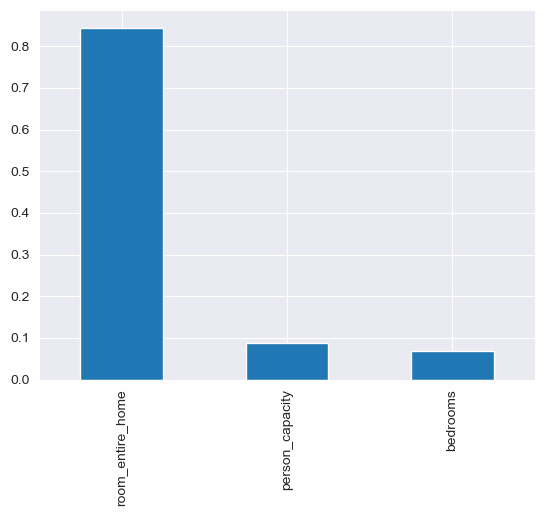

In [335]:
importance.plot.bar()

## 3. Model fine-tuning

### <u>Random Forest</u>

In [236]:
# Use the combination of features and target that performed best previously
X = london_copy[features2_log_imp2]
y = london_copy['price_log']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Perform randomized search to get the best hyper-parameter values

rf = RandomForestRegressor()

rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2,8,16,32,50],
    'min_samples_leaf': [2,4,6],
    'max_features': [None, 'log2', 'sqrt'],
    'bootstrap': [True, False],
    'warm_start': [True, False]
}

# Apply the cross-validated gridsearch on the random forest
rs = RandomizedSearchCV(rf, scoring='neg_root_mean_squared_error', verbose=2, param_distributions=rf_params, cv=10)

## Fit the search result on training data
rs.fit(X_train, y_train)

In [266]:
# Print out the best score
print(np.exp(abs(rs.best_score_)))

1.366271563678376


In [239]:
# Print out the best hyper-parameters
rs.best_params_

{'warm_start': True,
 'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [240]:
# Apply optimised hyper-parameters to the model
rf = RandomForestRegressor(warm_start=True,
                           n_estimators=200,
                           min_samples_split=2,
                           min_samples_leaf=2,
                           max_features='sqrt',
                           max_depth=20,
                           bootstrap=True)

# Fit model to training data
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=200, warm_start=True)

In [241]:
# K-fold cross-validation
rf_scores = abs(cross_val_score(rf, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(rf_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(rf_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(rf_scores))}')

The scores are: [1.34901221 1.33705055 1.35999675 1.33303291 1.33234208 1.33137261
 1.32488304 1.34827707 1.37552894 1.318841  ]
The mean of the scores is: 1.3410337145803692
The standard deviation of the scores is: 0.01721679127018645


In [242]:
# Check feature importance
importance = pd.Series(list(rf.feature_importances_), index=features2_log_imp2)
importance.sort_values(ascending=False, inplace=True)
importance

room_entire_home    0.420994
rest_index_log      0.226461
attr_index_log      0.182993
bedrooms            0.169551
dtype: float64

<AxesSubplot: >

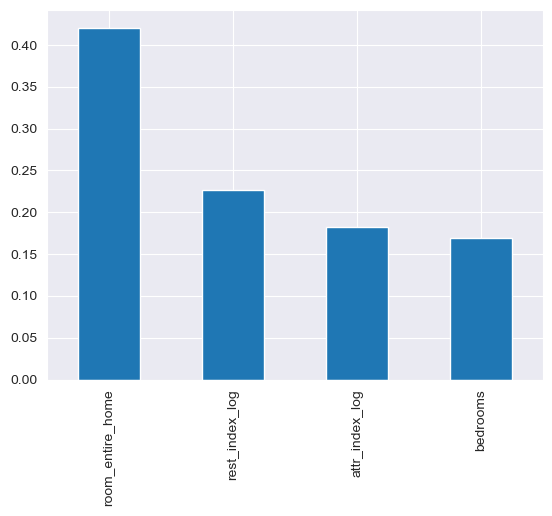

In [243]:
importance.plot.bar()

### <u>Extra Trees</u>

In [346]:
# Define features and target
X = london_copy[['room_entire_home', 'person_capacity', 'bedrooms']]
y = london_copy['price']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Perform randomized search
et = ExtraTreesRegressor()

et_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2,8,16,32,50],
    'min_samples_leaf': [2,4,6],
    'max_features': [None, 'log2', 'sqrt'],
    'bootstrap': [True, False],
    'warm_start': [True, False]
}

# Apply the cross-validated gridsearch on extra trees
rs2 = RandomizedSearchCV(et, scoring='neg_root_mean_squared_error', verbose=2, param_distributions=et_params, cv=10)

# Fit the search result on training data
rs2.fit(X_train, y_train)

In [343]:
# Print out the best score
print(np.exp(abs(rs2.best_score_)))

5.563560870234366e+35


In [344]:
# Print out the best hyper-parameters
rs2.best_params_

{'warm_start': False,
 'n_estimators': 150,
 'min_samples_split': 8,
 'min_samples_leaf': 6,
 'max_features': None,
 'max_depth': 20,
 'bootstrap': True}

In [345]:
# Apply optimised hyper-parameters to the model
et = ExtraTreesRegressor(warm_start=False,
                         n_estimators=150,
                         min_samples_split=8,
                         min_samples_leaf=6,
                         max_features=None,
                         max_depth=20,
                         bootstrap=True)

# Fit model to training data
et.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True, max_depth=20, max_features=None,
                    min_samples_leaf=6, min_samples_split=8, n_estimators=150)

In [347]:
# K-fold cross-validation (with original set of features)
et_scores = abs(cross_val_score(et, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10))
print(f'The scores are: {np.exp(rf_scores)}')
print(f'The mean of the scores is: {stats.mean(np.exp(rf_scores))}')
print(f'The standard deviation of the scores is: {stats.stdev(np.exp(rf_scores))}')

The scores are: [1.41464018 1.42587459 1.46754811 1.44398687 1.42889489 1.49289118
 1.43316767 1.44638683 1.42818507 1.43435094]
The mean of the scores is: 1.4415926323151922
The standard deviation of the scores is: 0.02302620064923793


After fine-tuning, the Random Forest model outperformed Extra Trees so let's select the former as the model of choice to predict Airbnb prices.

## 4. Model evaluation

In [351]:
# Define features and target
X = london_copy[features2_log_imp2]
y = london_copy['price_log']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [352]:
# Apply optimised hyper-parameters to the model
rf = RandomForestRegressor(warm_start=True,
                           n_estimators=200,
                           min_samples_split=2,
                           min_samples_leaf=2,
                           max_features='sqrt',
                           max_depth=20,
                           bootstrap=True)

# Fit model to training data
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=200, warm_start=True)

In [353]:
# Evaluate the model on test data
X_test['y_pred'] = rf.predict(X_test)
rmse = np.exp(statsmodels.tools.eval_measures.rmse(y_test, X_test['y_pred']))
print(rmse)

1.3618730741430272


In [354]:
# What features contributed to this result?
features2_log_imp2

['room_entire_home', 'bedrooms', 'rest_index_log', 'attr_index_log']

### Results summary

Ultimately, ensemble methods that utilise decision trees seemed to predict Airbnb prices better than linear regression which didn't account for any non-linear relationships between features and the target price. The better performance of these models also hinged on log-transforming the target price.

Factors related to the size of an Airbnb listing (whether an entire home was being rented, the number of bedrooms in the listing) and its proximity to an abundance of restaurants and tourist attractions seemed to be the biggest driving forces behind price prediction for the Random Forest model that was chosen as the best predictor.

### Improvements

<ul>
    <li><u>Better handling of known prices:</u> log-transforming the price may have misrepresented the behaviour of the target and therefore the nature of the problem that needed to be solved.</li>
    <li><u>More accurate known prices:</u> data that took into account actual prices previous customers paid (instead of advertised prices set by hosts on their listing) may have accounted for any inflation and extreme values; acquiring this data was outside the time and budget scope of this project.</li>
    <li><u>More data:</u> data that spanned a wider timeframe and was more representative of London as whole may have led to improvements.</li>
    <li><u>More time for model fine-tuning:</u> using GridSearch instead of RandomizedSearch would have accounted for all possible combinations of hyper-parameter values instead of a random sample.</li>
    <li><u>Explore more models:</u> spatial models that took into account spatial data was found to be more successful in the original study that used this data.</li>
    <li><u>Better performance metrics:</u> a metric like RMSPE (Root Mean Squared Percentage Error) instead of RMSE which looks at errors, or a metric that tries to optimise predicted prices towards the median price instead of the mean, as these account for extreme price values.</li>
</ul>